# 1. Data Preparation

### Loading Packages

In [134]:
import time
import logging
from tqdm import tqdm
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold, cross_validate, GridSearchCV, BaseCrossValidator
from sklearn.feature_selection import SelectFromModel, SelectKBest, VarianceThreshold, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix

import pingouin as pg
from scipy.stats import f_oneway, shapiro, kruskal
import scikit_posthocs as posthocs
from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from skbio.stats.distance import permanova
from skbio.diversity import beta_diversity
# also install necessary dependencies of the excel plugin of pandas

### Loading Functions

In [2]:
# function for getting a dataframes' column list
def get_columns(df: pd.DataFrame):
    return df.columns.to_list()

# function for moving a column to a new position
def move_column(df, col_name, new_position):
    temp_col = df[col_name]
    df = df.drop(columns=[col_name])
    df.insert(new_position, col_name, temp_col)
    return df

# function for converting a column to numeric
def convert_to_numeric(df):
    for col in df.columns:
        # Attempt to convert the column to numeric, setting errors='ignore' keeps the original data if conversion fails
        df[col] = pd.to_numeric(df[col], errors='ignore')
    return df

# function for getting the memory size of an object
def memory_size(bytes_size: int) -> str:
    for unit in ['Bytes', 'KB', 'MB', 'GB', 'TB']:
        if bytes_size < 1024:
            return f"{bytes_size:.2f} {unit}"
        bytes_size /= 1024
    return f"{bytes_size:.2f} PB"

In [3]:
# funtion for retrieving the sql database connector
def get_db_conn(db_path: str):
    try:
        conn = sql.connect(db_path) # connect to the SQLite database
        return conn
    except sql.Error as e:
        print(f"An error occurred while accessing the database: {e}")
        pass

# function for connecting a database object and returning its connector cursor
def get_db_cursor(db_path: str):
    try:
        conn = sql.connect(db_path) # connect to the SQLite database
        cursor = conn.cursor() # create a cursor object to execute SQL queries
        return cursor
    except sql.Error as e:
        print(f"An error occurred while accessing the database: {e}")
        pass

# function for viewing the available database tables
def get_db_tables(cursor: sql.Cursor):
    try:
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';") # cursor execution for retrieving the list of all tables
        db_tables = cursor.fetchall() # fetch the command output in a list object

        # view the list of tables
        temp = []
        for table in db_tables:
            temp.append(table[0])
        
        db_tables = temp
        return db_tables
    
    except sql.Error as e:
        print(f"An error occurred while accessing the database: {e}")
        return []

# function for extracting all available table columns in a dictionary
def get_db_columns(cursor: sql.Cursor):
    db_columns = {}
    
    for table in get_db_tables(cursor=cursor):
        cursor.execute(f"PRAGMA table_info({table});") # cursor call for retrieving table information
        cursor_output = cursor.fetchall() # cursor fetch operation to retrieve the SQL command output
        columns = [col[1] for col in cursor_output]
        db_columns[table] = columns

    for table in db_columns:
        print(f'{table}: {len(db_columns[table])} Columns')
        print(f'{table}: {db_columns[table]} Columns\n')

    return db_columns

# function for printing out the database table sizes
def get_db_size(cursor: sql.Cursor):
    for table in get_db_tables(cursor=cursor):
        # cursor call for executing SQL command 
        cursor.execute(f"SELECT COUNT(*) FROM {table};") 
        # fetch the first element of the cursor call output
        row_count = cursor.fetchone()[0] 
        
        # cursor command for retrieving column information
        cursor.execute(f"PRAGMA table_info({table});") 
        column_count = len(cursor.fetchall())
        
        # print the dimension and size information of each table
        print(f"{table} | Rows: {row_count} | Columns: {column_count} | Datapoints: {(row_count * column_count / 1000000):.1f}M")

def add_id_info(dataframes: dict):
    for table in dataframes.keys():
        if table == 'Image':
            # Split the FileName column into well information and picture number
            dataframes[table]['WellID'] = dataframes[table]['Image_FileName_CellOutlines'].str.split('--').str[0].str.split('_').str[0]
            dataframes[table]['FieldID'] = dataframes[table]['Image_FileName_CellOutlines'].str.split('--').str[0].str.split('_').str[1]
        else:
            # adding well ID and field ID to other tables
            dataframes[table] = dataframes[table].merge(dataframes['Image'][['TableNumber', 'WellID', 'FieldID']], on='TableNumber', how='left')
    
    return dataframes

def fix_columns(dataframes: dict):
    for table in dataframes:
        # change TableNumber to tableID in all of the tables
        dataframes[table].drop('TableNumber', axis=1, inplace=True)
        # dataframes[table].rename(columns={'TableNumber': 'TableID'}, inplace=True)

        # fix the order of the newly added columns
        dataframes[table] = move_column(dataframes[table], 'PlateID', 0)
        dataframes[table] = move_column(dataframes[table], 'WellID', 1)
        dataframes[table] = move_column(dataframes[table], 'FieldID', 2)

        # convert all numeric columns to float
        if table in ['Cells', 'Cytoplasm', 'Nuclei']:
            for eachColumn in dataframes[table].columns:
                if 'AreaShape' in eachColumn:
                    try:
                        # replace 'nan' strings with np.nan
                        pd.set_option('future.no_silent_downcasting', True)
                        dataframes[table][eachColumn] = dataframes[table][eachColumn].replace('nan', np.nan)
                        # attempt to convert the column to numeric type
                        dataframes[table][eachColumn] = pd.to_numeric(dataframes[table][eachColumn])
                        # print(f"Converted column '{eachColumn}' in table '{table}' to numeric.")
                    except ValueError:
                        # if conversion fails, leave the column unchanged
                        print(f"Could not convert column '{eachColumn}' in table '{table}'. Leaving it unchanged.")
    return dataframes

## Data: Bray et al. (2017)

The Cell Image Library has a “Human U2OS Cell: Compound Cell-Painting Experiment” project data that contains the images of 375 plates in 384-well format (More details: https://www.cellimagelibrary.org/pages/project_20269): 

- The images are of U2OS cells treated with each of over 30,000 known bioactive compounds.
- These cells are labeled with 6 labels that characterize seven organelles (the cell-painting assay).
- The data set is comprised of 988,994 fields of view.
- Each field was imaged in five channels (detection wavelengths), and each channel is stored as a separate, grayscale image file.
- As a result, there are approximately 5 million image files in 16-bit TIFF format.

Bray et al. (2017)’s research uses the raw image data of, and includes highly multiplexed measurements of cellular morphology of the tested compounds from the above Human U2OS Cell research. It includes:

- data files containing morphological features derived from each cell in each image (both at the single-cell level and population-averaged, i.e. per-well level),
- the image analysis workflows that generated the morphological features,
- quality-control metrics are provided as metadata,
- chemical annotations for the applied compound treatments.

- Description and files: http://gigadb.org/dataset/view/id/100351/Files_page/1
- Codebase: https://github.com/gigascience/paper-bray2017/tree/master


### Loading Databases

In [4]:
# list of plate IDs being extracted
analysis_mode = 'live'
plate_list = {'live': [24279, 24280, 24293, 24294, 24295, 24296, 24300, 24301, 24302, 24303],
              'test': [24279, 24280, 24293]}

# dictionary of required columns inside each of the sqlite database tables
df_columns = {}
df_columns['Image'] = ['TableNumber', 'Image_Count_Cells', 'Image_Count_Cytoplasm', 'Image_Count_Nuclei', 'Image_ExecutionTime_01LoadData', 'Image_ExecutionTime_02CorrectIlluminationApply', 'Image_ExecutionTime_03MeasureImageQuality', 'Image_ExecutionTime_04MeasureImageQuality', 'Image_ExecutionTime_06IdentifyPrimaryObjects', 'Image_ExecutionTime_07IdentifySecondaryObjects', 'Image_ExecutionTime_08IdentifyTertiaryObjects', 'Image_ExecutionTime_09MeasureCorrelation', 'Image_ExecutionTime_10MeasureGranularity', 'Image_ExecutionTime_11MeasureObjectIntensity', 'Image_ExecutionTime_12MeasureObjectNeighbors', 'Image_ExecutionTime_13MeasureObjectNeighbors', 'Image_ExecutionTime_14MeasureObjectNeighbors', 'Image_ExecutionTime_15MeasureObjectIntensityDistribution', 'Image_ExecutionTime_16MeasureObjectSizeShape', 'Image_ExecutionTime_17MeasureTexture', 'Image_ExecutionTime_18OverlayOutlines', 'Image_ExecutionTime_19OverlayOutlines', 'Image_ExecutionTime_20SaveImages', 'Image_ExecutionTime_21SaveImages', 'Image_FileName_CellOutlines', 'Image_FileName_IllumAGP', 'Image_FileName_IllumDNA', 'Image_FileName_IllumER', 'Image_FileName_IllumMito', 'Image_FileName_IllumRNA', 'Image_FileName_NucleiOutlines', 'Image_FileName_OrigAGP', 'Image_FileName_OrigDNA', 'Image_FileName_OrigER', 'Image_FileName_OrigMito', 'Image_FileName_OrigRNA']
df_columns['Nuclei'] = ['TableNumber', 'ImageNumber', 'ObjectNumber', 'Nuclei_AreaShape_Area', 'Nuclei_AreaShape_Center_X', 'Nuclei_AreaShape_Center_Y', 'Nuclei_AreaShape_Compactness', 'Nuclei_AreaShape_Eccentricity', 'Nuclei_AreaShape_EulerNumber', 'Nuclei_AreaShape_Extent', 'Nuclei_AreaShape_FormFactor', 'Nuclei_AreaShape_MajorAxisLength', 'Nuclei_AreaShape_MaxFeretDiameter', 'Nuclei_AreaShape_MaximumRadius', 'Nuclei_AreaShape_MeanRadius', 'Nuclei_AreaShape_MedianRadius', 'Nuclei_AreaShape_MinFeretDiameter', 'Nuclei_AreaShape_MinorAxisLength', 'Nuclei_AreaShape_Orientation', 'Nuclei_AreaShape_Perimeter', 'Nuclei_AreaShape_Solidity']
df_columns['Cytoplasm'] = ['TableNumber', 'ImageNumber', 'ObjectNumber', 'Cytoplasm_AreaShape_Area', 'Cytoplasm_AreaShape_Center_X', 'Cytoplasm_AreaShape_Center_Y', 'Cytoplasm_AreaShape_Compactness', 'Cytoplasm_AreaShape_Eccentricity', 'Cytoplasm_AreaShape_EulerNumber', 'Cytoplasm_AreaShape_Extent', 'Cytoplasm_AreaShape_FormFactor', 'Cytoplasm_AreaShape_MajorAxisLength', 'Cytoplasm_AreaShape_MaxFeretDiameter', 'Cytoplasm_AreaShape_MaximumRadius', 'Cytoplasm_AreaShape_MeanRadius', 'Cytoplasm_AreaShape_MedianRadius', 'Cytoplasm_AreaShape_MinFeretDiameter', 'Cytoplasm_AreaShape_MinorAxisLength', 'Cytoplasm_AreaShape_Orientation', 'Cytoplasm_AreaShape_Perimeter', 'Cytoplasm_AreaShape_Solidity']
df_columns['Cells'] = ['TableNumber', 'ImageNumber', 'ObjectNumber', 'Cells_AreaShape_Area', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y', 'Cells_AreaShape_Compactness', 'Cells_AreaShape_Eccentricity', 'Cells_AreaShape_EulerNumber', 'Cells_AreaShape_Extent', 'Cells_AreaShape_FormFactor', 'Cells_AreaShape_MajorAxisLength', 'Cells_AreaShape_MaxFeretDiameter', 'Cells_AreaShape_MaximumRadius', 'Cells_AreaShape_MeanRadius', 'Cells_AreaShape_MedianRadius', 'Cells_AreaShape_MinFeretDiameter', 'Cells_AreaShape_MinorAxisLength', 'Cells_AreaShape_Orientation', 'Cells_AreaShape_Perimeter', 'Cells_AreaShape_Solidity']

def load_dataframes(analysis_mode: str):

    # create a blank dictionary to save each table as a dataframe
    dataframes = {}
    # initialize the dictionary with creating each table with specified columns + plateID column
    for table in df_columns.keys():
        dataframes[table] = pd.DataFrame(columns=df_columns[table] + ['PlateID'])

    for plate in tqdm(plate_list[analysis_mode], desc="Loading SQLite Databases", unit="database"):
    # for plate, lap in list(zip(plate_list[analysis_mode], range(len(plate_list[analysis_mode])))):

        t1 = time.time()

        # update path to the sqlite database
        db_path = '../Data/bray2017/'+str(plate)+'/extracted_features/'+str(plate)+'.sqlite'
        # update db connector and cursor
        conn = get_db_conn(db_path=db_path)
        cursor = get_db_cursor(db_path=db_path)

        # for table in tqdm(get_db_tables(cursor), desc="Loading Database Tables", unit="table"):
        for table in get_db_tables(cursor):
            
            # update the query with the next table name and column information
            query = f"SELECT {', '.join(df_columns[table])} FROM {table};"
            
            # extract the dataframe using query
            temp = pd.read_sql_query(query, conn)

            # add plateID information to newly extracted dataframe
            temp['PlateID'] = plate

            # append the fresh dataframe with the existing dataframe
            if dataframes[table].empty:
                dataframes[table] = temp
            else:
                dataframes[table] = pd.concat([dataframes[table], temp], ignore_index=True)
            
            # print(f"PlateID: {plate} - Table: {table} | Success")
        
        t2 = time.time() - t1
        # print(f"Plate: {plate}, ETC: {(t2 * (len(plate_list[analysis_mode]) - lap)) / 60:.0f}m")

        # close the connection when the sqlite database processing is done
        conn.close()

    # add wellID and fieldID information to all dataframes
    dataframes = add_id_info(dataframes)

    # fix the column orders and data types
    dataframes = fix_columns(dataframes)

    return dataframes

dataframes = load_dataframes(analysis_mode)

Loading SQLite Databases: 100%|██████████| 10/10 [02:33<00:00, 15.38s/database]


### Combining Dataframes

In [5]:
# merge three morphological feature dataframes
morph_df = pd.merge(pd.merge(dataframes['Cells'],
                                     dataframes['Nuclei'].drop(columns=['ImageNumber']),
                                     on=['PlateID', 'WellID', 'FieldID', 'ObjectNumber'],
                                     how='inner'),
                                     dataframes['Cytoplasm'].drop(columns=['ImageNumber']),
                                     on=['PlateID', 'WellID', 'FieldID', 'ObjectNumber'],
                                     how='inner')
morph_df

,PlateID,WellID,FieldID,ImageNumber,ObjectNumber,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,...,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MaxFeretDiameter,Cytoplasm_AreaShape_MaximumRadius,Cytoplasm_AreaShape_MeanRadius,Cytoplasm_AreaShape_MedianRadius,Cytoplasm_AreaShape_MinFeretDiameter,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Perimeter,Cytoplasm_AreaShape_Solidity
0,24279,a01,s1,1,1,1671,220.0,0.0,1.320862,0.848385,...,75.830024,75.716577,12.529964,3.618276,3.000000,37.467049,34.541500,-44.544363,321.884,0.568387
1,24279,a01,s1,1,2,1349,45.0,20.0,1.045094,0.558345,...,50.670097,47.707442,13.341664,3.746856,3.000000,37.830553,42.399353,-84.010757,241.668,0.640055
2,24279,a01,s1,1,3,1672,179.0,0.0,1.107739,0.660926,...,64.143207,65.115282,10.630146,3.254621,2.828427,41.318874,47.190589,-52.665624,302.674,0.507351
3,24279,a01,s1,1,4,1465,486.0,22.0,1.093044,0.585346,...,59.516128,56.586217,14.560220,3.952490,3.000000,38.647774,42.958275,-84.475452,289.120,0.444773
4,24279,a01,s1,1,5,1244,111.0,51.0,1.363284,0.890779,...,52.841038,59.841457,10.198039,3.730092,3.000000,29.584427,27.794047,73.790450,257.846,0.539286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2382377,24303,p24,s6,2304,114,3011,382.0,481.0,1.206769,0.756010,...,88.715389,86.833173,12.083046,3.775260,3.162278,58.863912,55.830550,44.819343,557.278,0.613230
2382378,24303,p24,s6,2304,115,1430,56.0,483.0,1.495481,0.908388,...,78.941836,74.846510,7.810250,2.548488,2.236068,31.785375,31.699708,16.244996,340.056,0.561663
2382379,24303,p24,s6,2304,116,1543,116.0,486.0,1.287290,0.836868,...,66.784949,63.953108,10.198039,2.996980,2.236068,38.907583,38.133713,9.941202,316.572,0.596397
2382380,24303,p24,s6,2304,117,2135,228.0,500.0,1.746721,0.911662,...,94.358005,85.234969,10.295630,3.901708,3.605551,44.870011,35.734593,67.425415,396.304,0.561212


In [104]:
areashape_features = [col for col in morph_df.columns if 'AreaShape' in col]
areashape_features

['Cells_AreaShape_Area',
 'Cells_AreaShape_Center_X',
 'Cells_AreaShape_Center_Y',
 'Cells_AreaShape_Compactness',
 'Cells_AreaShape_Eccentricity',
 'Cells_AreaShape_EulerNumber',
 'Cells_AreaShape_Extent',
 'Cells_AreaShape_FormFactor',
 'Cells_AreaShape_MajorAxisLength',
 'Cells_AreaShape_MaxFeretDiameter',
 'Cells_AreaShape_MaximumRadius',
 'Cells_AreaShape_MeanRadius',
 'Cells_AreaShape_MedianRadius',
 'Cells_AreaShape_MinFeretDiameter',
 'Cells_AreaShape_MinorAxisLength',
 'Cells_AreaShape_Orientation',
 'Cells_AreaShape_Perimeter',
 'Cells_AreaShape_Solidity',
 'Nuclei_AreaShape_Area',
 'Nuclei_AreaShape_Center_X',
 'Nuclei_AreaShape_Center_Y',
 'Nuclei_AreaShape_Compactness',
 'Nuclei_AreaShape_Eccentricity',
 'Nuclei_AreaShape_EulerNumber',
 'Nuclei_AreaShape_Extent',
 'Nuclei_AreaShape_FormFactor',
 'Nuclei_AreaShape_MajorAxisLength',
 'Nuclei_AreaShape_MaxFeretDiameter',
 'Nuclei_AreaShape_MaximumRadius',
 'Nuclei_AreaShape_MeanRadius',
 'Nuclei_AreaShape_MedianRadius',
 'Nuc

### Dataframe Inspection

In [7]:
print(dataframes['Image'].info())
dataframes['Image']
# print(dataframes['Image'].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22927 entries, 0 to 22926
Data columns (total 38 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   PlateID                                                   22927 non-null  int64  
 1   WellID                                                    22927 non-null  object 
 2   FieldID                                                   22927 non-null  object 
 3   Image_Count_Cells                                         22927 non-null  float64
 4   Image_Count_Cytoplasm                                     22927 non-null  float64
 5   Image_Count_Nuclei                                        22927 non-null  float64
 6   Image_ExecutionTime_01LoadData                            22927 non-null  float64
 7   Image_ExecutionTime_02CorrectIlluminationApply            22927 non-null  float64
 8   Image_ExecutionT

,PlateID,WellID,FieldID,Image_Count_Cells,Image_Count_Cytoplasm,Image_Count_Nuclei,Image_ExecutionTime_01LoadData,Image_ExecutionTime_02CorrectIlluminationApply,Image_ExecutionTime_03MeasureImageQuality,Image_ExecutionTime_04MeasureImageQuality,...,Image_FileName_IllumDNA,Image_FileName_IllumER,Image_FileName_IllumMito,Image_FileName_IllumRNA,Image_FileName_NucleiOutlines,Image_FileName_OrigAGP,Image_FileName_OrigDNA,Image_FileName_OrigER,Image_FileName_OrigMito,Image_FileName_OrigRNA
0,24279,a01,s1,108.0,108.0,108.0,4.33,0.05,6.78,0.12,...,24279_IllumDNA.mat,24279_IllumER.mat,24279_IllumMito.mat,24279_IllumRNA.mat,a01_s1--nuclei_outlines.png,cdp2bioactives_a01_s1_w4b692e80d-7135-493b-a8e...,cdp2bioactives_a01_s1_w158c0d4fd-bdf2-4cd8-8c8...,cdp2bioactives_a01_s1_w2259ab177-e287-4573-96f...,cdp2bioactives_a01_s1_w519e2cf90-6757-4e5d-8c4...,cdp2bioactives_a01_s1_w3b6cef070-8d6b-4405-a90...
1,24279,a01,s2,85.0,85.0,85.0,4.44,0.04,7.43,0.12,...,24279_IllumDNA.mat,24279_IllumER.mat,24279_IllumMito.mat,24279_IllumRNA.mat,a01_s2--nuclei_outlines.png,cdp2bioactives_a01_s2_w4bf53f9a6-e58e-4948-888...,cdp2bioactives_a01_s2_w1e4863351-5e8c-419a-850...,cdp2bioactives_a01_s2_w20de06b65-35a2-413d-a4b...,cdp2bioactives_a01_s2_w500a68dcb-0652-4c7d-a36...,cdp2bioactives_a01_s2_w309068268-4286-43e3-b84...
2,24279,a01,s3,71.0,71.0,71.0,3.76,0.04,5.91,0.09,...,24279_IllumDNA.mat,24279_IllumER.mat,24279_IllumMito.mat,24279_IllumRNA.mat,a01_s3--nuclei_outlines.png,cdp2bioactives_a01_s3_w4798a8ead-cb54-4181-b06...,cdp2bioactives_a01_s3_w1969d35c0-4d37-4664-92c...,cdp2bioactives_a01_s3_w24e4b74b9-2b70-4f9b-b14...,cdp2bioactives_a01_s3_w58a03c55a-f98b-44cb-93b...,cdp2bioactives_a01_s3_w337b2e029-8665-4bc5-85c...
3,24279,a01,s4,84.0,84.0,84.0,3.77,0.04,5.88,0.12,...,24279_IllumDNA.mat,24279_IllumER.mat,24279_IllumMito.mat,24279_IllumRNA.mat,a01_s4--nuclei_outlines.png,cdp2bioactives_a01_s4_w492ed6097-ef63-4045-be0...,cdp2bioactives_a01_s4_w16006c0fc-6934-4283-859...,cdp2bioactives_a01_s4_w220ef0406-94b0-4a93-b54...,cdp2bioactives_a01_s4_w58b6c6b79-2a84-4845-b38...,cdp2bioactives_a01_s4_w3e0e93260-0dde-44e6-986...
4,24279,a01,s5,81.0,81.0,81.0,3.89,0.04,4.83,0.09,...,24279_IllumDNA.mat,24279_IllumER.mat,24279_IllumMito.mat,24279_IllumRNA.mat,a01_s5--nuclei_outlines.png,cdp2bioactives_a01_s5_w4e211557a-6121-4497-872...,cdp2bioactives_a01_s5_w1ce77fe7b-1d90-4be4-aca...,cdp2bioactives_a01_s5_w2147cdb67-b115-44b5-a4b...,cdp2bioactives_a01_s5_w5978b5dd6-e6ee-46e8-af5...,cdp2bioactives_a01_s5_w3cdf9b912-1b43-45e2-b92...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22922,24303,p24,s2,89.0,89.0,89.0,4.04,0.05,5.94,0.13,...,24303_IllumDNA.mat,24303_IllumER.mat,24303_IllumMito.mat,24303_IllumRNA.mat,p24_s2--nuclei_outlines.png,cdp2bioactives_p24_s2_w4bcc87ca6-ad21-4781-b5a...,cdp2bioactives_p24_s2_w166f2a520-d1d7-42b3-a8f...,cdp2bioactives_p24_s2_w2e95be122-2959-4f3d-a5f...,cdp2bioactives_p24_s2_w5f89fa493-95b7-4e9a-84a...,cdp2bioactives_p24_s2_w341872826-a5ac-4eb9-9a0...
22923,24303,p24,s3,109.0,109.0,109.0,4.19,0.04,6.61,0.13,...,24303_IllumDNA.mat,24303_IllumER.mat,24303_IllumMito.mat,24303_IllumRNA.mat,p24_s3--nuclei_outlines.png,cdp2bioactives_p24_s3_w448a16262-8174-4f48-8e8...,cdp2bioactives_p24_s3_w17925ff2c-9094-44ae-ad4...,cdp2bioactives_p24_s3_w219564082-89b4-47e7-879...,cdp2bioactives_p24_s3_w5619a8aea-e62b-477a-848...,cdp2bioactives_p24_s3_w30232b19a-d0d3-415d-933...
22924,24303,p24,s4,88.0,88.0,88.0,4.20,0.05,6.20,0.11,...,24303_IllumDNA.mat,24303_IllumER.mat,24303_IllumMito.mat,24303_IllumRNA.mat,p24_s4--nuclei_outlines.png,cdp2bioactives_p24_s4_w41de3281a-67b0-428d-984...,cdp2bioactives_p24_s4_w1c229f769-79ed-400b-ae4...,cdp2bioactives_p24_s4_w2b795ff4b-1658-4409-817...,cdp2bioactives_p24_s4_w51fd15cc6-3bb7-48b6-863...,cdp2bioactives_p24_s4_w307bc7426-2d97-475c-9d0...
22925,24303,p24,s5,95.0,95.0,95.0,4.22,0.04,7.26,0.13,...,24303_IllumDNA.mat,24303_IllumER.mat,24303_IllumMito.mat,24303_IllumRNA.mat,p24_s5

In [8]:
print(dataframes['Cells'].info())
dataframes['Cells']
# print(dataframes['Cells'].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2382382 entries, 0 to 2382381
Data columns (total 23 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   PlateID                           int64  
 1   WellID                            object 
 2   FieldID                           object 
 3   ImageNumber                       int64  
 4   ObjectNumber                      int64  
 5   Cells_AreaShape_Area              int64  
 6   Cells_AreaShape_Center_X          float64
 7   Cells_AreaShape_Center_Y          float64
 8   Cells_AreaShape_Compactness       float64
 9   Cells_AreaShape_Eccentricity      float64
 10  Cells_AreaShape_EulerNumber       float64
 11  Cells_AreaShape_Extent            float64
 12  Cells_AreaShape_FormFactor        float64
 13  Cells_AreaShape_MajorAxisLength   float64
 14  Cells_AreaShape_MaxFeretDiameter  float64
 15  Cells_AreaShape_MaximumRadius     float64
 16  Cells_AreaShape_MeanRadius        fl

,PlateID,WellID,FieldID,ImageNumber,ObjectNumber,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,...,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MaxFeretDiameter,Cells_AreaShape_MaximumRadius,Cells_AreaShape_MeanRadius,Cells_AreaShape_MedianRadius,Cells_AreaShape_MinFeretDiameter,Cells_AreaShape_MinorAxisLength,Cells_AreaShape_Orientation,Cells_AreaShape_Perimeter,Cells_AreaShape_Solidity
0,24279,a01,s1,1,1,1671,220.0,0.0,1.320862,0.848385,...,66.206195,75.716577,17.204651,7.242049,6.708204,37.467049,35.048248,-41.735695,221.980,0.889303
1,24279,a01,s1,1,2,1349,45.0,20.0,1.045094,0.558345,...,46.101933,47.707442,17.464249,7.193267,6.708204,37.830553,38.246565,86.030000,164.904,0.920505
2,24279,a01,s1,1,3,1672,179.0,0.0,1.107739,0.660926,...,54.898208,65.115282,20.591260,8.310686,7.615773,41.318874,41.198415,-52.526000,194.458,0.893879
3,24279,a01,s1,1,4,1465,486.0,22.0,1.093044,0.585346,...,49.581640,56.586217,17.464249,7.010790,6.324555,38.647774,40.199988,82.289142,184.458,0.867634
4,24279,a01,s1,1,5,1244,111.0,51.0,1.363284,0.890779,...,59.793360,59.841457,13.000000,5.378160,5.000000,29.584427,27.172260,68.355923,164.012,0.888571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2382377,24303,p24,s6,2304,114,3011,382.0,481.0,1.206769,0.756010,...,80.392006,86.833173,22.472205,7.443621,6.403124,58.863912,52.621401,42.049720,434.820,0.781064
2382378,24303,p24,s6,2304,115,1430,56.0,483.0,1.495481,0.908388,...,68.027799,74.846510,12.369317,4.829001,4.123106,31.785375,28.444306,16.341224,254.878,0.814583
2382379,24303,p24,s6,2304,116,1543,116.0,486.0,1.287290,0.836868,...,62.341759,63.953108,14.317821,5.511198,5.000000,38.907583,34.126214,9.419775,233.566,0.829793
2382380,24303,p24,s6,2304,117,2135,228.0,500.0,1.746721,0.911662,...,90.025095,85.234969,16.763055,5.771290,5.099020,44.870011,36.995021,61.168896,298.330,0.752158


In [9]:
print(dataframes['Nuclei'].info())
dataframes['Nuclei']
# print(dataframes['Nuclei'].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2382382 entries, 0 to 2382381
Data columns (total 23 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   PlateID                            int64  
 1   WellID                             object 
 2   FieldID                            object 
 3   ImageNumber                        int64  
 4   ObjectNumber                       int64  
 5   Nuclei_AreaShape_Area              int64  
 6   Nuclei_AreaShape_Center_X          float64
 7   Nuclei_AreaShape_Center_Y          float64
 8   Nuclei_AreaShape_Compactness       float64
 9   Nuclei_AreaShape_Eccentricity      float64
 10  Nuclei_AreaShape_EulerNumber       float64
 11  Nuclei_AreaShape_Extent            float64
 12  Nuclei_AreaShape_FormFactor        float64
 13  Nuclei_AreaShape_MajorAxisLength   float64
 14  Nuclei_AreaShape_MaxFeretDiameter  float64
 15  Nuclei_AreaShape_MaximumRadius     float64
 16  Nuclei_AreaShape_M

,PlateID,WellID,FieldID,ImageNumber,ObjectNumber,Nuclei_AreaShape_Area,Nuclei_AreaShape_Center_X,Nuclei_AreaShape_Center_Y,Nuclei_AreaShape_Compactness,Nuclei_AreaShape_Eccentricity,...,Nuclei_AreaShape_MajorAxisLength,Nuclei_AreaShape_MaxFeretDiameter,Nuclei_AreaShape_MaximumRadius,Nuclei_AreaShape_MeanRadius,Nuclei_AreaShape_MedianRadius,Nuclei_AreaShape_MinFeretDiameter,Nuclei_AreaShape_MinorAxisLength,Nuclei_AreaShape_Orientation,Nuclei_AreaShape_Perimeter,Nuclei_AreaShape_Solidity
0,24279,a01,s1,1,1,728,205.0,22.0,1.127143,0.790258,...,38.989849,38.078866,11.661904,4.864477,4.472136,23.306304,23.891959,-67.351303,106.974,0.949153
1,24279,a01,s1,1,2,507,48.0,24.0,1.002999,0.381632,...,26.458294,25.961510,12.000000,4.551340,4.000000,23.000000,24.455779,-86.928772,82.420,0.962049
2,24279,a01,s1,1,3,863,179.0,20.0,1.121519,0.782660,...,42.153135,41.048752,13.038405,5.270531,5.000000,25.455844,26.238216,-52.509394,114.700,0.957293
3,24279,a01,s1,1,4,842,490.0,26.0,1.051742,0.658802,...,37.959323,37.696154,14.000000,5.431949,5.000000,27.000000,28.557422,8.464802,110.318,0.961736
4,24279,a01,s1,1,5,609,103.0,34.0,1.183093,0.819366,...,37.180347,37.483330,10.816654,4.263577,4.000000,21.973728,21.314399,-82.501136,101.732,0.918552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2382377,24303,p24,s6,2304,114,801,370.0,483.0,1.346628,0.839363,...,46.044545,43.289722,10.295630,4.178874,4.000000,26.867911,25.028497,0.478549,128.114,0.864544
2382378,24303,p24,s6,2304,115,549,69.0,485.0,1.128556,0.792183,...,33.932193,32.984845,10.000000,4.310725,4.000000,20.056676,20.708249,12.197494,92.834,0.945736
2382379,24303,p24,s6,2304,116,539,117.0,488.0,1.084384,0.743570,...,32.099887,31.384710,10.770330,4.369595,4.000000,21.019039,21.463858,25.021531,90.490,0.946444
2382380,24303,p24,s6,2304,117,668,237.0,498.0,1.242405,0.858213,...,40.910021,39.408121,10.000000,4.437127,4.123106,20.101790,20.998847,40.143287,104.216,0.962536


In [10]:
print(dataframes['Cytoplasm'].info())
dataframes['Cytoplasm']
# print(dataframes['Cytoplasm'].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2382382 entries, 0 to 2382381
Data columns (total 23 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   PlateID                               int64  
 1   WellID                                object 
 2   FieldID                               object 
 3   ImageNumber                           int64  
 4   ObjectNumber                          int64  
 5   Cytoplasm_AreaShape_Area              int64  
 6   Cytoplasm_AreaShape_Center_X          float64
 7   Cytoplasm_AreaShape_Center_Y          float64
 8   Cytoplasm_AreaShape_Compactness       float64
 9   Cytoplasm_AreaShape_Eccentricity      float64
 10  Cytoplasm_AreaShape_EulerNumber       float64
 11  Cytoplasm_AreaShape_Extent            float64
 12  Cytoplasm_AreaShape_FormFactor        float64
 13  Cytoplasm_AreaShape_MajorAxisLength   float64
 14  Cytoplasm_AreaShape_MaxFeretDiameter  float64
 15  Cytoplasm_AreaS

,PlateID,WellID,FieldID,ImageNumber,ObjectNumber,Cytoplasm_AreaShape_Area,Cytoplasm_AreaShape_Center_X,Cytoplasm_AreaShape_Center_Y,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_Eccentricity,...,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MaxFeretDiameter,Cytoplasm_AreaShape_MaximumRadius,Cytoplasm_AreaShape_MeanRadius,Cytoplasm_AreaShape_MedianRadius,Cytoplasm_AreaShape_MinFeretDiameter,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Perimeter,Cytoplasm_AreaShape_Solidity
0,24279,a01,s1,1,1,1068,226.0,0.0,2.558095,0.890230,...,75.830024,75.716577,12.529964,3.618276,3.000000,37.467049,34.541500,-44.544363,321.884,0.568387
1,24279,a01,s1,1,2,938,42.0,0.0,1.829240,0.547550,...,50.670097,47.707442,13.341664,3.746856,3.000000,37.830553,42.399353,-84.010757,241.668,0.640055
2,24279,a01,s1,1,3,949,169.0,0.0,2.628430,0.677300,...,64.143207,65.115282,10.630146,3.254621,2.828427,41.318874,47.190589,-52.665624,302.674,0.507351
3,24279,a01,s1,1,4,751,482.0,0.0,2.821092,0.692110,...,59.516128,56.586217,14.560220,3.952490,3.000000,38.647774,42.958275,-84.475452,289.120,0.444773
4,24279,a01,s1,1,5,755,115.0,59.0,1.855410,0.850489,...,52.841038,59.841457,10.198039,3.730092,3.000000,29.584427,27.794047,73.790450,257.846,0.539286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2382377,24303,p24,s6,2304,114,2364,404.0,498.0,1.829777,0.777145,...,88.715389,86.833173,12.083046,3.775260,3.162278,58.863912,55.830550,44.819343,557.278,0.613230
2382378,24303,p24,s6,2304,115,986,87.0,493.0,2.888248,0.915834,...,78.941836,74.846510,7.810250,2.548488,2.236068,31.785375,31.699708,16.244996,340.056,0.561663
2382379,24303,p24,s6,2304,116,1109,142.0,490.0,2.097727,0.820955,...,66.784949,63.953108,10.198039,2.996980,2.236068,38.907583,38.133713,9.941202,316.572,0.596397
2382380,24303,p24,s6,2304,117,1593,217.0,473.0,2.516100,0.925514,...,94.358005,85.234969,10.295630,3.901708,3.605551,44.870011,35.734593,67.425415,396.304,0.561212


In [11]:
# view columns with null counts
print(morph_df.isnull().sum()[morph_df.isnull().sum() > 0])

Cells_AreaShape_Compactness            91
Cells_AreaShape_Eccentricity           91
Cells_AreaShape_FormFactor             91
Cells_AreaShape_MajorAxisLength        91
Cells_AreaShape_MinorAxisLength        91
Cells_AreaShape_Orientation            91
Cytoplasm_AreaShape_Compactness        91
Cytoplasm_AreaShape_Eccentricity       91
Cytoplasm_AreaShape_FormFactor         91
Cytoplasm_AreaShape_MajorAxisLength    91
Cytoplasm_AreaShape_MinorAxisLength    91
Cytoplasm_AreaShape_Orientation        91
dtype: int64


In [12]:
morph_df.columns[morph_df.isnull().any()].tolist()

['Cells_AreaShape_Compactness',
 'Cells_AreaShape_Eccentricity',
 'Cells_AreaShape_FormFactor',
 'Cells_AreaShape_MajorAxisLength',
 'Cells_AreaShape_MinorAxisLength',
 'Cells_AreaShape_Orientation',
 'Cytoplasm_AreaShape_Compactness',
 'Cytoplasm_AreaShape_Eccentricity',
 'Cytoplasm_AreaShape_FormFactor',
 'Cytoplasm_AreaShape_MajorAxisLength',
 'Cytoplasm_AreaShape_MinorAxisLength',
 'Cytoplasm_AreaShape_Orientation']

In [13]:
# subset the dataframe that has null values in any row
morph_df[morph_df.isnull().any(axis=1)]

,PlateID,WellID,FieldID,ImageNumber,ObjectNumber,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,...,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MaxFeretDiameter,Cytoplasm_AreaShape_MaximumRadius,Cytoplasm_AreaShape_MeanRadius,Cytoplasm_AreaShape_MedianRadius,Cytoplasm_AreaShape_MinFeretDiameter,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Perimeter,Cytoplasm_AreaShape_Solidity
1930,24279,a05,s2,26,10,0,0.0,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
49057,24279,d09,s5,485,100,0,0.0,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
62099,24279,e06,s5,611,14,0,0.0,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
123570,24279,i08,s5,1199,117,0,0.0,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
138743,24279,j09,s4,1348,57,0,0.0,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2352866,24303,n22,s5,2003,35,0,0.0,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
2366523,24303,o22,s2,2144,13,0,0.0,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
2366528,24303,o22,s2,2144,18,0,0.0,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
2370358,24303,p04,s6,2184,24,0,0.0,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0


In [92]:
# finally remove the instances that have null values
morph_df = morph_df.dropna()

print(morph_df.isnull().sum()[morph_df.isnull().sum() > 0])
morph_df[morph_df.isnull().any(axis=1)]

Series([], dtype: int64)


,PlateID,WellID,FieldID,ImageNumber,ObjectNumber,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,...,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MaxFeretDiameter,Cytoplasm_AreaShape_MaximumRadius,Cytoplasm_AreaShape_MeanRadius,Cytoplasm_AreaShape_MedianRadius,Cytoplasm_AreaShape_MinFeretDiameter,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Perimeter,Cytoplasm_AreaShape_Solidity


## Data: Seal et al. (2024)

Ola linked the compounds identified in the BioMorph study with the metadata of the Cell Painting dataset. She linked 603 compounds, which results in 5025 wells spread over 94 different plates.
- CPD_NAME: specific compounds
- Metadata_Plate: specific plates
- Metadata_Well: specific wells

### Endpoint Definitions

1. Apoptosis Up:
- Apoptosis is the process of programmed cell death, where cells die in a controlled manner as part of normal development or in response to damage.
- "**Apoptosis up**" means an increase in the rate of apoptosis in response to a compound, suggesting the compound is inducing cell death via the apoptotic pathway. This could be important in cancer treatments, where the goal is to promote the death of harmful cells.
 2. Cytotoxicity BLA:
- Cytotoxicity refers to the toxic effect a compound has on cells, leading to cell damage or death.
- BLA stands for Beta-Lactamase assay, a biochemical assay often used to detect cytotoxicity. The "**Cytotoxicity BLA**" endpoint indicates cell death or damage measured through the Beta-Lactamase assay.
 3. Cytotoxicity SRB:
- Similar to Cytotoxicity BLA, this measures cell toxicity, but using a different assay.
- SRB stands for Sulforhodamine B, a dye that binds to cellular proteins, and it’s commonly used to measure cell density and viability. The "**Cytotoxicity SRB**" endpoint measures the cytotoxic effect of compounds based on the amount of protein-bound SRB dye, indicating cell death or reduced viability.
 4. ER Stress:
- ER stress refers to stress in the Endoplasmic Reticulum (ER), a cell organelle involved in protein folding and secretion. When misfolded proteins accumulate, ER stress triggers the Unfolded Protein Response (UPR).
- The "ER stress" endpoint indicates that a compound is causing stress in the ER, potentially leading to apoptosis or other cellular dysfunctions.
 5. Heat Shock:
- Heat shock refers to the stress response of cells to elevated temperatures, which results in the production of heat shock proteins (HSPs) that help protect cells from damage.
- The "Heat Shock" endpoint suggests the compound is inducing a cellular response similar to what happens when cells are exposed to heat or other stresses, typically leading to the production of HSPs.
 6. Microtubule Up:
- Microtubules are part of the cell's cytoskeleton and are crucial for cell division and intracellular transport.
- "Microtubule up" indicates an increase in microtubule stabilization or polymerization due to the compound. Compounds that affect microtubules can disrupt cell division, making this endpoint important in cancer research (e.g., chemotherapy drugs like taxanes target microtubules).
 7. Mitochondrial Disruption Up:
- Mitochondria are the energy-producing organelles in cells, and mitochondrial disruption can lead to cell death or dysfunction.
- "Mitochondrial disruption up" indicates an increase in mitochondrial dysfunction, which can lead to cellular energy depletion and apoptosis. This endpoint is used to measure the impact of a compound on mitochondrial health.
 8. Oxidative Stress Up:
- Oxidative stress occurs when there is an imbalance between the production of reactive oxygen species (ROS) and the cell’s ability to detoxify them, leading to cellular damage.
- "Oxidative stress up" means the compound is causing an increase in oxidative stress, which can damage DNA, proteins, and lipids, potentially leading to cell death.
 9. Proliferation Decrease:
- Proliferation refers to the growth and division of cells. A decrease in proliferation means that the cells are dividing more slowly or not at all.
- "Proliferation decrease" indicates that the compound is inhibiting cell growth. This endpoint is often used in cancer research to evaluate the efficacy of treatments designed to slow or stop the growth of tumor cells.

### Loading & Cleaning

In [14]:
# read the xlsx file
biomorph = pd.read_excel("../Data/olaBiomorph/603_compounds_metadata.xlsx")

# choose the important columns
biomorph_columns = ['Metadata_Plate',	
                    'Metadata_Well',	
                    'CPD_NAME',	'CPD_SAMPLE_ID',	
                    'apoptosis up',	
                    'cytotoxicity BLA',
                    'cytotoxicity SRB',	
                    'ER stress',	
                    'heat shock',	
                    'microtubule up',	
                    'mitochondrial disruption up',	
                    'oxidative stress up', 
                    'proliferation decrease']

# list of toxicity endpoints
endpoint_columns = ['apoptosis up', 'cytotoxicity BLA', 'cytotoxicity SRB', 'ER stress', 
                    'heat shock', 'microtubule up', 'mitochondrial disruption up', 
                    'oxidative stress up', 'proliferation decrease']

# remove the unnecessary columns
biomorph = biomorph.loc[:, biomorph_columns]

# improve the column names
biomorph.rename(columns={'Metadata_Plate': 'PlateID'}, inplace=True)
biomorph.rename(columns={'Metadata_Well': 'WellID'}, inplace=True)

# remove the unused plate information
biomorph = biomorph[biomorph.PlateID.isin(plate_list[analysis_mode])]

# create a column with total endpoint sum
biomorph['total_endpoints'] = biomorph[endpoint_columns].sum(axis=1)

# add a column with a tuple list of total endpoint activities
biomorph['endpoint_combination'] = biomorph[endpoint_columns].apply(tuple, axis=1)

# quick inspection
print(biomorph.shape)
print(biomorph.info())

# print the snippet of the cleaned dataset
biomorph

(850, 15)
<class 'pandas.core.frame.DataFrame'>
Index: 850 entries, 202 to 1139
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   PlateID                      850 non-null    int64 
 1   WellID                       850 non-null    object
 2   CPD_NAME                     850 non-null    object
 3   CPD_SAMPLE_ID                850 non-null    object
 4   apoptosis up                 850 non-null    int64 
 5   cytotoxicity BLA             850 non-null    int64 
 6   cytotoxicity SRB             850 non-null    int64 
 7   ER stress                    850 non-null    int64 
 8   heat shock                   850 non-null    int64 
 9   microtubule up               850 non-null    int64 
 10  mitochondrial disruption up  850 non-null    int64 
 11  oxidative stress up          850 non-null    int64 
 12  proliferation decrease       850 non-null    int64 
 13  total_endpoints            

,PlateID,WellID,CPD_NAME,CPD_SAMPLE_ID,apoptosis up,cytotoxicity BLA,cytotoxicity SRB,ER stress,heat shock,microtubule up,mitochondrial disruption up,oxidative stress up,proliferation decrease,total_endpoints,endpoint_combination
202,24279,a03,olmesartan medoxomil,SA59556,0,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
203,24279,a06,citropten,SA59278,0,0,0,0,0,0,1,0,0,1,"(0, 0, 0, 0, 0, 0, 1, 0, 0)"
204,24279,a09,bromperidol,SA83338,0,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
205,24279,a10,leflunomide,SA792771,1,1,0,1,1,0,0,1,0,5,"(1, 1, 0, 1, 1, 0, 0, 1, 0)"
206,24279,a11,suxibuzone,SA58544,0,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,24303,p06,bifonazole,SA59850,1,1,0,1,1,0,0,0,0,4,"(1, 1, 0, 1, 1, 0, 0, 0, 0)"
1136,24303,p07,bucladesine,SA82230,0,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
1137,24303,p10,metaxalone,SA59546,0,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
1138,24303,p17,nisoxetine,SA792281,0,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"


### Merging Endpoints & Cell Stats

In [15]:
# merge morphological features with annotations... 
biomorph_cell_stats = morph_df.merge(biomorph,
                                     on=['PlateID', 'WellID'],
                                     how='right') # ...but only keeps the wells that appear in biomorph annotation

# combine plateID and wellID to create a groupID for stratified folding
biomorph_cell_stats['GroupID'] = biomorph_cell_stats['PlateID'].astype(str) + '_' + biomorph_cell_stats['WellID'].astype(str)
biomorph_cell_stats = move_column(biomorph_cell_stats, 'GroupID', 2)

biomorph_cell_stats

,PlateID,WellID,GroupID,FieldID,ImageNumber,ObjectNumber,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,...,cytotoxicity BLA,cytotoxicity SRB,ER stress,heat shock,microtubule up,mitochondrial disruption up,oxidative stress up,proliferation decrease,total_endpoints,endpoint_combination
0,24279,a03,24279_a03,s1,13,1,2794,121.0,0.0,2.308547,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
1,24279,a03,24279_a03,s1,13,2,3864,365.0,0.0,1.206172,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
2,24279,a03,24279_a03,s1,13,3,953,414.0,28.0,1.246423,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
3,24279,a03,24279_a03,s1,13,4,2349,695.0,25.0,1.397739,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
4,24279,a03,24279_a03,s1,13,5,1802,311.0,34.0,1.260998,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534304,24303,p18,24303_p18,s6,2268,120,1123,165.0,495.0,1.100898,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
534305,24303,p18,24303_p18,s6,2268,121,2387,536.0,496.0,1.108895,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
534306,24303,p18,24303_p18,s6,2268,122,1232,198.0,501.0,1.163976,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
534307,24303,p18,24303_p18,s6,2268,123,1287,498.0,519.0,1.181055,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"


In [100]:
print(list(areashape_features))

['Cells_AreaShape_Area', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y', 'Cells_AreaShape_Compactness', 'Cells_AreaShape_Eccentricity', 'Cells_AreaShape_EulerNumber', 'Cells_AreaShape_Extent', 'Cells_AreaShape_FormFactor', 'Cells_AreaShape_MajorAxisLength', 'Cells_AreaShape_MaxFeretDiameter', 'Cells_AreaShape_MaximumRadius', 'Cells_AreaShape_MeanRadius', 'Cells_AreaShape_MedianRadius', 'Cells_AreaShape_MinFeretDiameter', 'Cells_AreaShape_MinorAxisLength', 'Cells_AreaShape_Orientation', 'Cells_AreaShape_Perimeter', 'Cells_AreaShape_Solidity', 'Nuclei_AreaShape_Area', 'Nuclei_AreaShape_Center_X', 'Nuclei_AreaShape_Center_Y', 'Nuclei_AreaShape_Compactness', 'Nuclei_AreaShape_Eccentricity', 'Nuclei_AreaShape_EulerNumber', 'Nuclei_AreaShape_Extent', 'Nuclei_AreaShape_FormFactor', 'Nuclei_AreaShape_MajorAxisLength', 'Nuclei_AreaShape_MaxFeretDiameter', 'Nuclei_AreaShape_MaximumRadius', 'Nuclei_AreaShape_MeanRadius', 'Nuclei_AreaShape_MedianRadius', 'Nuclei_AreaShape_MinFeretDiameter'

In [93]:
print(list(biomorph_cell_stats.columns))

['PlateID', 'WellID', 'GroupID', 'FieldID', 'ImageNumber', 'ObjectNumber', 'Cells_AreaShape_Area', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y', 'Cells_AreaShape_Compactness', 'Cells_AreaShape_Eccentricity', 'Cells_AreaShape_EulerNumber', 'Cells_AreaShape_Extent', 'Cells_AreaShape_FormFactor', 'Cells_AreaShape_MajorAxisLength', 'Cells_AreaShape_MaxFeretDiameter', 'Cells_AreaShape_MaximumRadius', 'Cells_AreaShape_MeanRadius', 'Cells_AreaShape_MedianRadius', 'Cells_AreaShape_MinFeretDiameter', 'Cells_AreaShape_MinorAxisLength', 'Cells_AreaShape_Orientation', 'Cells_AreaShape_Perimeter', 'Cells_AreaShape_Solidity', 'Nuclei_AreaShape_Area', 'Nuclei_AreaShape_Center_X', 'Nuclei_AreaShape_Center_Y', 'Nuclei_AreaShape_Compactness', 'Nuclei_AreaShape_Eccentricity', 'Nuclei_AreaShape_EulerNumber', 'Nuclei_AreaShape_Extent', 'Nuclei_AreaShape_FormFactor', 'Nuclei_AreaShape_MajorAxisLength', 'Nuclei_AreaShape_MaxFeretDiameter', 'Nuclei_AreaShape_MaximumRadius', 'Nuclei_AreaShape_MeanRad

### Dataframe Inspection

In [17]:
# view columns with null counts
print(biomorph_cell_stats.isnull().sum()[biomorph_cell_stats.isnull().sum() > 0])

Cells_AreaShape_Compactness            20
Cells_AreaShape_Eccentricity           20
Cells_AreaShape_FormFactor             20
Cells_AreaShape_MajorAxisLength        20
Cells_AreaShape_MinorAxisLength        20
Cells_AreaShape_Orientation            20
Cytoplasm_AreaShape_Compactness        20
Cytoplasm_AreaShape_Eccentricity       20
Cytoplasm_AreaShape_FormFactor         20
Cytoplasm_AreaShape_MajorAxisLength    20
Cytoplasm_AreaShape_MinorAxisLength    20
Cytoplasm_AreaShape_Orientation        20
dtype: int64


In [89]:
# remove the rows that have null values
biomorph_cell_stats = biomorph_cell_stats.dropna()

# inspect the columns again
print(biomorph_cell_stats.isnull().sum()[biomorph_cell_stats.isnull().sum() > 0])

Series([], dtype: int64)


# 2. Explatory Data Analysis

## Well & Field Stats

In [115]:
# grouped aggregation for each field (grouped by PlateID, WellID, and FieldID)
field_stats = biomorph_cell_stats.groupby(['PlateID', 'WellID', 'FieldID'])[areashape_features].agg(['mean', 'std']).reset_index()

# grouped aggregation for each well (grouped by PlateID and WellID)
well_stats = biomorph_cell_stats.groupby(['PlateID', 'WellID'])[areashape_features].agg(['mean', 'std']).reset_index()

# rename the columns for better readability (e.g., Cells_AreaShape_Area_mean, Cells_AreaShape_Area_std)
field_stats.columns = ['_'.join(col).strip() if col[1] else col[0] for col in field_stats.columns]
well_stats.columns = ['_'.join(col).strip() if col[1] else col[0] for col in well_stats.columns]

print(list(field_stats.columns))
print(list(well_stats.columns))

['PlateID', 'WellID', 'FieldID', 'Cells_AreaShape_Area_mean', 'Cells_AreaShape_Area_std', 'Cells_AreaShape_Center_X_mean', 'Cells_AreaShape_Center_X_std', 'Cells_AreaShape_Center_Y_mean', 'Cells_AreaShape_Center_Y_std', 'Cells_AreaShape_Compactness_mean', 'Cells_AreaShape_Compactness_std', 'Cells_AreaShape_Eccentricity_mean', 'Cells_AreaShape_Eccentricity_std', 'Cells_AreaShape_EulerNumber_mean', 'Cells_AreaShape_EulerNumber_std', 'Cells_AreaShape_Extent_mean', 'Cells_AreaShape_Extent_std', 'Cells_AreaShape_FormFactor_mean', 'Cells_AreaShape_FormFactor_std', 'Cells_AreaShape_MajorAxisLength_mean', 'Cells_AreaShape_MajorAxisLength_std', 'Cells_AreaShape_MaxFeretDiameter_mean', 'Cells_AreaShape_MaxFeretDiameter_std', 'Cells_AreaShape_MaximumRadius_mean', 'Cells_AreaShape_MaximumRadius_std', 'Cells_AreaShape_MeanRadius_mean', 'Cells_AreaShape_MeanRadius_std', 'Cells_AreaShape_MedianRadius_mean', 'Cells_AreaShape_MedianRadius_std', 'Cells_AreaShape_MinFeretDiameter_mean', 'Cells_AreaShape_

In [116]:
well_stats

,PlateID,WellID,Cells_AreaShape_Area_mean,Cells_AreaShape_Area_std,Cells_AreaShape_Center_X_mean,Cells_AreaShape_Center_X_std,Cells_AreaShape_Center_Y_mean,Cells_AreaShape_Center_Y_std,Cells_AreaShape_Compactness_mean,Cells_AreaShape_Compactness_std,...,Cytoplasm_AreaShape_MinFeretDiameter_mean,Cytoplasm_AreaShape_MinFeretDiameter_std,Cytoplasm_AreaShape_MinorAxisLength_mean,Cytoplasm_AreaShape_MinorAxisLength_std,Cytoplasm_AreaShape_Orientation_mean,Cytoplasm_AreaShape_Orientation_std,Cytoplasm_AreaShape_Perimeter_mean,Cytoplasm_AreaShape_Perimeter_std,Cytoplasm_AreaShape_Solidity_mean,Cytoplasm_AreaShape_Solidity_std
0,24279,a03,2819.551155,1244.936354,348.399340,193.294754,250.074257,143.953181,1.389197,0.310683,...,49.817279,12.700982,49.018457,12.260347,-0.716429,50.305619,408.302977,102.332344,0.614961,0.083123
1,24279,a06,2867.075646,1382.125199,329.151292,192.641151,252.411439,141.998967,1.401067,0.355199,...,50.036707,12.751942,49.148246,12.330268,3.157065,51.416605,413.062841,108.209940,0.621667,0.078891
2,24279,a09,2759.120141,1542.465241,342.337456,197.679192,259.621908,145.318357,1.316239,0.254566,...,49.736047,13.335309,49.483226,12.694051,-1.782109,53.236069,409.371134,136.586336,0.592151,0.088105
3,24279,a10,2743.187285,1325.546709,341.953608,194.538873,256.467354,136.652863,1.319033,0.275721,...,49.764824,13.333475,49.604085,13.429471,0.416494,52.520882,407.581993,114.706458,0.596662,0.085077
4,24279,a11,2309.964286,1067.978195,346.064286,191.313239,263.918571,141.931517,1.306339,0.253962,...,46.494603,11.668147,46.075733,11.103696,-4.058044,54.238263,378.774271,100.896378,0.559310,0.092092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,24303,p06,2225.185581,1036.020850,351.403204,193.559910,266.120160,141.427289,1.296773,0.235204,...,46.068768,12.148102,45.729737,11.933102,-2.504463,52.709564,378.848686,97.822249,0.560374,0.088390
846,24303,p07,2726.045752,1245.487871,354.413399,188.011188,255.754902,142.369056,1.381299,0.345055,...,49.410296,12.763526,48.395627,12.187250,-8.428007,52.697691,416.724183,131.904074,0.612622,0.069862
847,24303,p10,2417.003145,1198.063389,343.976415,195.280645,266.396226,138.203115,1.333029,0.258294,...,47.368884,13.497653,46.765467,12.931770,-4.040474,53.774310,412.182248,117.444617,0.564446,0.079610
848,24303,p17,2394.437186,1107.053489,363.157454,195.819827,254.142379,138.278782,1.388628,0.371295,...,46.476890,11.301491,45.856154,10.901340,-1.223770,52.930244,395.837454,103.766814,0.578455,0.077424


In [117]:
field_stats

,PlateID,WellID,FieldID,Cells_AreaShape_Area_mean,Cells_AreaShape_Area_std,Cells_AreaShape_Center_X_mean,Cells_AreaShape_Center_X_std,Cells_AreaShape_Center_Y_mean,Cells_AreaShape_Center_Y_std,Cells_AreaShape_Compactness_mean,...,Cytoplasm_AreaShape_MinFeretDiameter_mean,Cytoplasm_AreaShape_MinFeretDiameter_std,Cytoplasm_AreaShape_MinorAxisLength_mean,Cytoplasm_AreaShape_MinorAxisLength_std,Cytoplasm_AreaShape_Orientation_mean,Cytoplasm_AreaShape_Orientation_std,Cytoplasm_AreaShape_Perimeter_mean,Cytoplasm_AreaShape_Perimeter_std,Cytoplasm_AreaShape_Solidity_mean,Cytoplasm_AreaShape_Solidity_std
0,24279,a03,s1,2629.943925,1170.772442,380.261682,184.776833,235.906542,138.219850,1.406135,...,47.789038,12.499598,47.157217,11.612704,9.848844,52.091265,397.879944,105.356369,0.590879,0.102745
1,24279,a03,s2,2498.822034,1148.257957,348.889831,194.618662,252.974576,137.745614,1.321503,...,48.612173,12.997782,48.406780,13.211597,-6.212075,51.719373,390.758864,104.204869,0.576794,0.084585
2,24279,a03,s3,2720.053571,1215.061455,337.294643,189.480021,230.794643,151.569931,1.389608,...,48.663288,11.958446,47.490865,10.928393,-3.885913,51.172094,400.948357,104.606243,0.605735,0.073503
3,24279,a03,s4,2964.170213,1267.757937,331.829787,196.918390,264.319149,146.415759,1.398101,...,51.508303,14.575340,50.537673,14.108631,-4.896643,52.021605,421.916681,96.297511,0.632589,0.073216
4,24279,a03,s5,3073.384615,1466.327027,301.208791,200.183889,266.593407,145.324922,1.407812,...,51.471590,13.190076,50.627401,12.688364,-1.263282,44.247243,421.248791,110.014948,0.646896,0.059042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5086,24303,p18,s2,3109.423077,1379.339250,316.923077,170.066585,298.833333,138.847802,1.514465,...,51.084701,13.727984,49.611965,12.893435,10.942535,48.602165,437.312538,120.330135,0.615175,0.073797
5087,24303,p18,s3,2578.938596,1350.536919,397.631579,179.732114,234.429825,140.623326,1.389115,...,47.613640,12.327711,46.703452,11.463370,4.012973,58.099710,401.394368,130.815114,0.581232,0.076123
5088,24303,p18,s4,3708.552632,2219.205089,273.631579,187.451532,260.815789,146.848305,1.466416,...,56.166062,16.846479,54.070571,15.458926,-6.683184,54.900167,475.273947,149.930429,0.656333,0.061376
5089,24303,p18,s5,2543.876190,1415.528963,401.152381,187.574846,257.504762,133.502386,1.324628,...,48.402705,14.355449,48.002399,14.336117,3.291146,56.521192,435.146552,156.530224,0.569785,0.070414


## Adding Cell Counts

In [118]:
# calculate the cells counts of each plate, each well and each field
cells_per_plate = dataframes['Cells'].groupby('PlateID').size().reset_index(name='Cell_Count')
cells_per_well = dataframes['Cells'].groupby(['PlateID', 'WellID']).size().reset_index(name='Cell_Count')
cells_per_field = dataframes['Cells'].groupby(['PlateID', 'WellID', 'FieldID']).size().reset_index(name='Cell_Count')

# merge cell counts with respective field_stats and well_stats dataframes
well_stats = well_stats.merge(
    right=cells_per_well[['PlateID', 'WellID', 'Cell_Count']],
    on=['PlateID', 'WellID'],
    how='left'
)

field_stats = field_stats.merge(
    right=cells_per_field[['PlateID', 'WellID', 'FieldID', 'Cell_Count']],
    on=['PlateID', 'WellID', 'FieldID'],
    how='left'
)

well_stats[['PlateID', 'WellID', 'Cell_Count']]

,PlateID,WellID,Cell_Count
0,24279,a03,606
1,24279,a06,542
2,24279,a09,566
3,24279,a10,582
4,24279,a11,700
...,...,...,...
845,24303,p06,749
846,24303,p07,612
847,24303,p10,636
848,24303,p17,597


In [119]:
field_stats[['PlateID', 'WellID', 'FieldID', 'Cell_Count']]

,PlateID,WellID,FieldID,Cell_Count
0,24279,a03,s1,107
1,24279,a03,s2,118
2,24279,a03,s3,112
3,24279,a03,s4,94
4,24279,a03,s5,91
...,...,...,...,...
5086,24303,p18,s2,78
5087,24303,p18,s3,114
5088,24303,p18,s4,38
5089,24303,p18,s5,105


## Adding Endpoints

In [120]:
# combine well stats with endpoints, but only keep the wellIDs that have endpoint annotation
biomorph_well_stats = well_stats.merge(
    right=biomorph,
    on=['PlateID', 'WellID'],
    how='right'
)

biomorph_well_stats

,PlateID,WellID,Cells_AreaShape_Area_mean,Cells_AreaShape_Area_std,Cells_AreaShape_Center_X_mean,Cells_AreaShape_Center_X_std,Cells_AreaShape_Center_Y_mean,Cells_AreaShape_Center_Y_std,Cells_AreaShape_Compactness_mean,Cells_AreaShape_Compactness_std,...,cytotoxicity BLA,cytotoxicity SRB,ER stress,heat shock,microtubule up,mitochondrial disruption up,oxidative stress up,proliferation decrease,total_endpoints,endpoint_combination
0,24279,a03,2819.551155,1244.936354,348.399340,193.294754,250.074257,143.953181,1.389197,0.310683,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
1,24279,a06,2867.075646,1382.125199,329.151292,192.641151,252.411439,141.998967,1.401067,0.355199,...,0,0,0,0,0,1,0,0,1,"(0, 0, 0, 0, 0, 0, 1, 0, 0)"
2,24279,a09,2759.120141,1542.465241,342.337456,197.679192,259.621908,145.318357,1.316239,0.254566,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
3,24279,a10,2743.187285,1325.546709,341.953608,194.538873,256.467354,136.652863,1.319033,0.275721,...,1,0,1,1,0,0,1,0,5,"(1, 1, 0, 1, 1, 0, 0, 1, 0)"
4,24279,a11,2309.964286,1067.978195,346.064286,191.313239,263.918571,141.931517,1.306339,0.253962,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,24303,p06,2225.185581,1036.020850,351.403204,193.559910,266.120160,141.427289,1.296773,0.235204,...,1,0,1,1,0,0,0,0,4,"(1, 1, 0, 1, 1, 0, 0, 0, 0)"
846,24303,p07,2726.045752,1245.487871,354.413399,188.011188,255.754902,142.369056,1.381299,0.345055,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
847,24303,p10,2417.003145,1198.063389,343.976415,195.280645,266.396226,138.203115,1.333029,0.258294,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
848,24303,p17,2394.437186,1107.053489,363.157454,195.819827,254.142379,138.278782,1.388628,0.371295,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"


In [122]:
# combine field stats with endpoints, but only keep the wellIDs that have endpoint annotation
biomorph_field_stats = field_stats.merge(
    right=biomorph.merge(dataframes['Cells'][['PlateID', 'WellID', 'FieldID']].drop_duplicates(),
                         on=['PlateID', 'WellID'], 
                         how='left'),
    on=['PlateID', 'WellID', 'FieldID'],
    how='right'
)

biomorph_field_stats

,PlateID,WellID,FieldID,Cells_AreaShape_Area_mean,Cells_AreaShape_Area_std,Cells_AreaShape_Center_X_mean,Cells_AreaShape_Center_X_std,Cells_AreaShape_Center_Y_mean,Cells_AreaShape_Center_Y_std,Cells_AreaShape_Compactness_mean,...,cytotoxicity BLA,cytotoxicity SRB,ER stress,heat shock,microtubule up,mitochondrial disruption up,oxidative stress up,proliferation decrease,total_endpoints,endpoint_combination
0,24279,a03,s1,2629.943925,1170.772442,380.261682,184.776833,235.906542,138.219850,1.406135,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
1,24279,a03,s2,2498.822034,1148.257957,348.889831,194.618662,252.974576,137.745614,1.321503,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
2,24279,a03,s3,2720.053571,1215.061455,337.294643,189.480021,230.794643,151.569931,1.389608,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
3,24279,a03,s4,2964.170213,1267.757937,331.829787,196.918390,264.319149,146.415759,1.398101,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
4,24279,a03,s5,3073.384615,1466.327027,301.208791,200.183889,266.593407,145.324922,1.407812,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5086,24303,p18,s2,3109.423077,1379.339250,316.923077,170.066585,298.833333,138.847802,1.514465,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
5087,24303,p18,s3,2578.938596,1350.536919,397.631579,179.732114,234.429825,140.623326,1.389115,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
5088,24303,p18,s4,3708.552632,2219.205089,273.631579,187.451532,260.815789,146.848305,1.466416,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"
5089,24303,p18,s5,2543.876190,1415.528963,401.152381,187.574846,257.504762,133.502386,1.324628,...,0,0,0,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0)"


## Compound & Endpoint Combination

In [21]:
print(f"The number of samples with no endpoint activity: {biomorph[biomorph['total_endpoints'] == 0].shape[0]}")
print(f"The number of samples with a singular endpoint activity: {biomorph[biomorph['total_endpoints'] == 1].shape[0]}")
print(f"The number of samples with a multiple endpoint activities: {biomorph[biomorph['total_endpoints'] > 1].shape[0]}")

The number of samples with no endpoint activity: 521
The number of samples with a singular endpoint activity: 152
The number of samples with a multiple endpoint activities: 177


In [22]:
# retrieve the occurrence counts of endpoint activities
endpoint_combination_counts = biomorph['endpoint_combination'].value_counts()

# group by endpoint combination and then count unique compounds in each group
endpoint_compound_counts = biomorph.groupby('endpoint_combination')['CPD_NAME'].nunique()
endpoint_compound_counts = endpoint_compound_counts.sort_values(ascending=False)

print(f'Endpoint Combination Counts:\n{endpoint_combination_counts}\n')
print(f'Endpoint Compound Counts:\n{endpoint_compound_counts}')

Endpoint Combination Counts:
endpoint_combination
(0, 0, 0, 0, 0, 0, 0, 0, 0)    521
(0, 1, 0, 0, 0, 0, 0, 0, 0)     56
(1, 0, 0, 0, 0, 0, 0, 0, 0)     53
(0, 0, 0, 0, 0, 0, 0, 1, 0)     19
(1, 1, 0, 0, 0, 0, 0, 0, 0)     19
(1, 1, 0, 1, 1, 0, 0, 0, 0)     16
(0, 0, 0, 0, 0, 0, 1, 0, 0)      9
(1, 1, 1, 1, 1, 0, 1, 1, 1)      8
(1, 1, 0, 1, 0, 0, 0, 0, 0)      7
(1, 0, 0, 0, 0, 0, 1, 1, 1)      6
(1, 0, 0, 0, 1, 0, 0, 0, 0)      6
(0, 0, 0, 0, 0, 0, 0, 0, 1)      6
(1, 0, 1, 1, 0, 0, 0, 1, 1)      6
(0, 0, 0, 1, 0, 0, 0, 1, 0)      6
(0, 0, 0, 0, 1, 0, 0, 0, 0)      5
(0, 0, 0, 0, 0, 0, 0, 1, 1)      4
(1, 1, 1, 1, 1, 1, 0, 1, 1)      4
(0, 0, 0, 0, 0, 0, 1, 0, 1)      4
(1, 0, 1, 1, 0, 1, 0, 1, 1)      4
(1, 1, 1, 1, 1, 0, 0, 1, 1)      4
(1, 0, 1, 0, 0, 0, 1, 1, 1)      4
(1, 0, 0, 1, 0, 0, 0, 0, 0)      4
(0, 0, 1, 0, 0, 0, 0, 1, 1)      4
(1, 1, 0, 1, 1, 0, 0, 1, 0)      4
(1, 1, 1, 1, 1, 1, 1, 1, 1)      4
(1, 1, 0, 0, 1, 0, 0, 0, 0)      4
(1, 1, 0, 1, 1, 0, 1, 1, 1)      3
(1, 0

In [23]:
# all of the compounds only results in a single endpoint combination
for eachCompound in biomorph['CPD_NAME'].unique():
    if len(biomorph[biomorph['CPD_NAME'] == eachCompound]['endpoint_combination'].unique()) != 1:
        print(f"{eachCompound} has multiple occurring endpoint combinations")

In [24]:
# calculate total occurrences of each compound
compound_counts = biomorph['CPD_NAME'].value_counts().reset_index()
compound_counts.columns = ['CPD_NAME', 'Total_Occurrences']

# find the most frequent endpoint combination for each compound
most_common_combinations = biomorph.groupby(['CPD_NAME', 'endpoint_combination']).size().reset_index(name='Count')
most_common_combinations = most_common_combinations.sort_values(['CPD_NAME', 'Count'], ascending=[True, False])

# get the top combination for each compound
most_common_combinations = most_common_combinations.drop_duplicates(subset='CPD_NAME', keep='first')

# merge with total occurrences and calculate decimal percentage
compound_summary = pd.merge(compound_counts, most_common_combinations, on='CPD_NAME')
compound_summary['Decimal_Percentage'] = compound_summary['Count'] / compound_summary['Total_Occurrences']

# rename columns for clarity
compound_summary.columns = ['CPD_NAME', 'Total_Occurrences', 'Most_Common_Combination', 'Occurrence_with_Combination', 'Decimal_Percentage']

# sort by total occurrences in descending order
compound_summary = compound_summary.sort_values(by='Total_Occurrences', ascending=False).reset_index(drop=True)
compound_summary

,CPD_NAME,Total_Occurrences,Most_Common_Combination,Occurrence_with_Combination,Decimal_Percentage
0,bucladesine,9,"(0, 0, 0, 0, 0, 0, 0, 0, 0)",9,1.0
1,anabasine,7,"(0, 0, 0, 0, 0, 0, 0, 0, 0)",7,1.0
2,ondansetron,6,"(0, 0, 0, 0, 0, 0, 0, 0, 0)",6,1.0
3,propranolol,6,"(0, 0, 0, 0, 0, 0, 0, 0, 0)",6,1.0
4,dihydroergocristine,6,"(0, 0, 0, 0, 0, 0, 0, 0, 0)",6,1.0
...,...,...,...,...,...
329,deoxycorticosterone acetate,1,"(1, 0, 0, 0, 0, 0, 0, 0, 0)",1,1.0
330,levcromakalim,1,"(0, 0, 0, 0, 0, 0, 0, 0, 0)",1,1.0
331,paraxanthine,1,"(0, 0, 0, 0, 0, 0, 0, 0, 0)",1,1.0
332,coumarin,1,"(0, 0, 0, 0, 0, 0, 1, 0, 1)",1,1.0


## Statistical Testing

**What's our problem?**
- We need to understand whether **every site for a well** is as representative for the *end-points* as the next, or if there’s a good deal of heterogeneity if we were to consider the data on a site-level vs a well level.
- Therefore, the goal is to measure **heterogeneity across fields** within each well.
- If there is high variability across fields, it suggests that a single well-level average may not capture all the underlying variability, which could justify a more granular analysis at the site level.

**How to proceed?**
1. **Test for normality:** Assess if each feature within each site follows a normal distribution, which impacts the choice of parametric vs. non-parametric tests.
    - Shapiro-Wilk test for univariate, Henze-Zirkler's test for multivariate normality if using multiple features
    - Count the number of features that pass/fail normality across fields and wells to evaluate if parametric assumptions hold.
2. **Statistical Testing for Differences Across Sites:** Determine if the observed variability across sites within each well is statistically significant by proceeding with a parametric or non-parametric tests based on normality results.
	- **MANOVA (parametric, for multivariate data)** if normality holds across fields within a well.
	- **PERMANOVA (non-parametric, for multivariate data)** if normality does not hold.
	- **ANOVA or Kruskal-Wallis** for univariate data (for each feature separately).

**What are the options?**
1. I can use **ANOVA (Analysis of Variance)** test to see whether there are statistically significant differences in the means of a variable (in this case, cell metrics like area) across multiple groups (fields within each well).
    - I could have compared the cell-feature means of each field inside a well, but then I'd have very few number of instances (at most 6) for statistical tests.
    - That's why I directly used single-cell metrics instead of field-level aggregates for ANOVA, which helps to improve the statistical power of the test.
    - ***Adding endpoint/compound into the test***: Since the endpoint combination is the same across all fields in each well, it won’t vary within the well. This makes it less relevant for ANOVA, as I'm not *comparing across different endpoint labels* but rather *testing consistency within the fields assigned the same endpoint*.
        - If, however, **significant heterogeneity within fields** for wells labeled with the same endpoint combination is observed, this would indicate that some fields may not represent that endpoint as consistently as others. In such cases, I should follow up by **examining whether certain endpoint combinations show more heterogeneity** across fields than others, which could highlight specific conditions that are less consistent across fields.
    - **Interpretation**: Low p-value (< 0.05) indicates statistically significant differences in a feature between fields within a well. This suggests that field-level heterogeneity exists, supporting the need for site- or single-cell level analysis. High p-value suggests that field-level averages are more similar, implying less heterogeneity across fields within the well.

### Normality Testing

Although **MANOVA** has **multivariate normality** requirement, which means that the distribution of each feature and all combinations of features should be normally distributed within each group (in your case, within each field in a well). This assumption ensures accurate results in MANOVA, as it affects the validity of p-values.

This requirement can be tested by:
- **Univariate Normality: Shapiro-Wilk Test** test each feature individually within each field. It tests normality, but don’t capture interactions between features.

- **Multivariate Normality: Henze-Zirkler test** is more suited for testing multivariate normality across features simultaneously, making it ideal before applying MANOVA. It has a good overall power against alternatives to normality and works for any dimension and sample size.

#### Univariate Normality: Shapiro-Wilk

- The Shapiro-Wilk test can be applied to each field’s feature data within each well to check for **univariate normality** on a per-feature basis.
- The p-value indicates the likelihood of observing the given data if it were normally distributed. 
    - **High p-value** indicates that there's no strong evidence to reject the null hypothesis that the data follows a normal distribution.
    - **Low p-value** causes the null hypothesis of normality to be rejected, suggesting that the data deviates significantly from a normal distribution.

In [546]:
# list to store shapiro-wilk test results
shapiro_results = []
lap_counter = 0

# iterate over each plate and well combination
for plate_id, well_id in dataframes['Cells'][['PlateID', 'WellID']].drop_duplicates().values:

    well_start_time = time.time()
    lap_counter += 1
    
    # subset the respective cell and nuclei data
    well_data_cells = dataframes['Cells'][(dataframes['Cells']['PlateID'] == plate_id) & 
                                          (dataframes['Cells']['WellID'] == well_id)]
    well_data_nuclei = dataframes['Nuclei'][(dataframes['Nuclei']['PlateID'] == plate_id) & 
                                            (dataframes['Nuclei']['WellID'] == well_id)]
    
    # merge cell and nuclei data with an outer join
    well_data = well_data_cells.merge(well_data_nuclei, on=['TableID', 'PlateID', 'WellID', 'FieldID', 'ImageNumber', 'ObjectNumber'], how='outer')
    
    # define the features to include in MANOVA and Mardia's test
    features = ['Cells_AreaShape_Area', 'Cells_AreaShape_Compactness', 'Nuclei_AreaShape_Area', 'Nuclei_AreaShape_Compactness']
    
    # iterate over each field within this well
    for field_id in well_data['FieldID'].unique():
        
        # subset the feature data for the current field
        field_data = well_data[well_data['FieldID'] == field_id][['Cells_AreaShape_Area',
                                                                  'Cells_AreaShape_Compactness',
                                                                  'Nuclei_AreaShape_Area',
                                                                  'Nuclei_AreaShape_Compactness']].dropna()
        
        # only perform shapiro-wilk test if there is enough data
        if len(field_data) > 3:
            for feature in field_data.columns:

                # perform shapiro-wilk test for the current feature
                stat, p_value = shapiro(field_data[feature])
                
                # append the results together
                shapiro_results.append({
                    'PlateID': plate_id,
                    'WellID': well_id,
                    'FieldID': field_id,
                    'Feature': feature,
                    'Shapiro_stat': stat,
                    'Shapiro_p_value': p_value,
                    'Normality': p_value > 0.05  # True if the feature data is normal
                })
    
    well_end_time = time.time() - well_start_time
    print(f"Plate: {plate_id}, Well: {well_id}, ETC: {(well_end_time * (len(dataframes['Cells'][['PlateID', 'WellID']].drop_duplicates())
                                                                         - lap_counter)) / 60:.0f}m")

# convert results to df
shapiro_results_df = pd.DataFrame(shapiro_results)
print("Shapiro-Wilk Test Results for Each Field's Feature Data:")
shapiro_results_df

Plate: 24278, Well: a01, ETC: 2m
Plate: 24278, Well: a02, ETC: 2m
Plate: 24278, Well: a03, ETC: 2m
Plate: 24278, Well: a04, ETC: 2m
Plate: 24278, Well: a05, ETC: 2m
Plate: 24278, Well: a06, ETC: 2m
Plate: 24278, Well: a07, ETC: 2m
Plate: 24278, Well: a08, ETC: 2m
Plate: 24278, Well: a09, ETC: 2m
Plate: 24278, Well: a10, ETC: 2m
Plate: 24278, Well: a11, ETC: 2m
Plate: 24278, Well: a12, ETC: 2m
Plate: 24278, Well: a13, ETC: 2m
Plate: 24278, Well: a14, ETC: 2m
Plate: 24278, Well: a15, ETC: 2m
Plate: 24278, Well: a16, ETC: 2m
Plate: 24278, Well: a17, ETC: 2m
Plate: 24278, Well: a18, ETC: 2m
Plate: 24278, Well: a19, ETC: 2m
Plate: 24278, Well: a20, ETC: 2m
Plate: 24278, Well: a21, ETC: 2m
Plate: 24278, Well: a22, ETC: 2m
Plate: 24278, Well: a23, ETC: 2m
Plate: 24278, Well: a24, ETC: 2m
Plate: 24278, Well: b01, ETC: 2m
Plate: 24278, Well: b02, ETC: 2m
Plate: 24278, Well: b03, ETC: 2m
Plate: 24278, Well: b04, ETC: 2m
Plate: 24278, Well: b05, ETC: 2m
Plate: 24278, Well: b06, ETC: 2m
Plate: 242

,PlateID,WellID,FieldID,Feature,Shapiro_Stat,Shapiro_p_value,Normality
0,24278,a01,s1,Cells_AreaShape_Area,0.524586,1.995330e-12,False
1,24278,a01,s1,Cells_AreaShape_Compactness,0.908840,3.564252e-04,False
2,24278,a01,s1,Nuclei_AreaShape_Area,0.462340,2.962369e-13,False
3,24278,a01,s1,Nuclei_AreaShape_Compactness,0.848451,3.766189e-06,False
4,24278,a01,s4,Cells_AreaShape_Area,0.501347,2.138397e-12,False
...,...,...,...,...,...,...,...
27287,24280,p24,s5,Nuclei_AreaShape_Compactness,0.814072,6.618734e-09,False
27288,24280,p24,s4,Cells_AreaShape_Area,0.932374,3.719401e-03,False
27289,24280,p24,s4,Cells_AreaShape_Compactness,0.796479,2.304788e-07,False
27290,24280,p24,s4,Nuclei_AreaShape_Area,0.819737,8.705807e-07,False


In [579]:
# subset the tests that result in not rejecting normality
true_normality = shapiro_results_df[shapiro_results_df['Normality']]
# group the normality counts by each plateID and feature
shapiro_summary1 = (true_normality.groupby(['PlateID', 'Feature'])
                    .size()
                    .unstack(fill_value=0))

# count the total number of fields for each plateID and add as a column
shapiro_summary1 = shapiro_summary1.merge(shapiro_results_df.groupby('PlateID')['FieldID'].count().reset_index(name='Field_Count'),
                                          on='PlateID',
                                          how='left')
shapiro_summary1 = move_column(shapiro_summary1, 'Field_Count', 1)

print("Shapiro-Wilk Test Results Summary:\nUnivariate Normality Counts per Feature")
shapiro_summary1

Shapiro-Wilk Test Results Summary:
Univariate Normality Counts per Feature


,PlateID,Field_Count,Cells_AreaShape_Area,Cells_AreaShape_Compactness,Nuclei_AreaShape_Area,Nuclei_AreaShape_Compactness
0,24278,9076,112,16,43,25
1,24279,9104,76,11,28,13
2,24280,9112,52,8,19,10


#### Multivariate Normality: Henze-Zirkler

The Henze-Zirkler test is more suited for testing multivariate normality across features simultaneously, making it ideal before applying MANOVA. It has a good overall power against alternatives to normality and works for any dimension and sample size.

In [551]:
# list to store MANOVA results
henze_results = []
lap_counter = 0

# parse through each well & plate combination
for plate_id, well_id in dataframes['Cells'][['PlateID', 'WellID']].drop_duplicates().values:

    well_start_time = time.time()
    lap_counter += 1

    # subset the respective cell and nuclei data
    well_data_cells = dataframes['Cells'][(dataframes['Cells']['PlateID'] == plate_id) & 
                                          (dataframes['Cells']['WellID'] == well_id)]
    well_data_nuclei = dataframes['Nuclei'][(dataframes['Nuclei']['PlateID'] == plate_id) & 
                                            (dataframes['Nuclei']['WellID'] == well_id)]
    
    # merge cell and nuclei data with an outer join
    well_data = well_data_cells.merge(well_data_nuclei, on=['PlateID', 'WellID', 'FieldID', 'ImageNumber', 'ObjectNumber'], how='outer')
    
    # define the features to include in MANOVA and Mardia's test
    features = ['Cells_AreaShape_Area', 'Cells_AreaShape_Compactness', 'Nuclei_AreaShape_Area', 'Nuclei_AreaShape_Compactness']

    # ensure well_data has non-empty data for all required features before proceeding
    if well_data[features].dropna().shape[0] > 0:
        
        # iterate over each field within this well
        for field_id in well_data['FieldID'].unique():

            # subset the feature data for HZ's test
            field_data = well_data[well_data['FieldID'] == field_id][features].dropna()
            
            # only proceed with HZ's test if we have enough data
            if len(field_data) > 3:

                # execute HZ's multivariate normality test
                henze_test = pg.multivariate_normality(field_data, alpha=0.05)
                # extract normality result
                henze_stat = henze_test.hz
                henze_p_value = henze_test.pval
                henze_normal = henze_test.normal

                # append combined results to the list
                henze_results.append({
                    'PlateID': plate_id,
                    'WellID': well_id,
                    'FieldID': field_id,
                    'Henze_stat': henze_stat,
                    'Henze_p_value': henze_p_value,
                    'Normality': henze_normal,
                })
    else:
        print(f"Skipping henze-wirkler test for PlateID: {plate_id}, WellID: {well_id} due to insufficient data.")
    
    well_end_time = time.time() - well_start_time
    print(f"Plate: {plate_id}, Well: {well_id}, ETC: {(well_end_time * (len(dataframes['Cells'][['PlateID', 'WellID']].drop_duplicates())
                                                                         - lap_counter)) / 60:.0f} minutes")

# convert results to dataframe
henze_results_df = pd.DataFrame(henze_results)
henze_results_df

Plate: 24278, Well: a01, ETC: 2 minutes
Plate: 24278, Well: a02, ETC: 2 minutes
Plate: 24278, Well: a03, ETC: 2 minutes
Plate: 24278, Well: a04, ETC: 2 minutes
Plate: 24278, Well: a05, ETC: 2 minutes
Plate: 24278, Well: a06, ETC: 2 minutes
Plate: 24278, Well: a07, ETC: 2 minutes
Plate: 24278, Well: a08, ETC: 2 minutes
Plate: 24278, Well: a09, ETC: 2 minutes
Plate: 24278, Well: a10, ETC: 2 minutes
Plate: 24278, Well: a11, ETC: 2 minutes
Plate: 24278, Well: a12, ETC: 2 minutes
Plate: 24278, Well: a13, ETC: 2 minutes
Plate: 24278, Well: a14, ETC: 2 minutes
Plate: 24278, Well: a15, ETC: 2 minutes
Plate: 24278, Well: a16, ETC: 2 minutes
Plate: 24278, Well: a17, ETC: 2 minutes
Plate: 24278, Well: a18, ETC: 2 minutes
Plate: 24278, Well: a19, ETC: 2 minutes
Plate: 24278, Well: a20, ETC: 2 minutes
Plate: 24278, Well: a21, ETC: 2 minutes
Plate: 24278, Well: a22, ETC: 2 minutes
Plate: 24278, Well: a23, ETC: 2 minutes
Plate: 24278, Well: a24, ETC: 2 minutes
Plate: 24278, Well: b01, ETC: 2 minutes


,PlateID,WellID,FieldID,Henze_stat,Henze_p_value,Normality
0,24278,a01,s1,2.968566,6.189672e-24,False
1,24278,a01,s2,1.410125,2.554677e-06,False
2,24278,a01,s3,1.258537,5.721446e-05,False
3,24278,a01,s4,3.555454,5.979282e-30,False
4,24278,a01,s5,0.883602,5.037093e-02,True
...,...,...,...,...,...,...
6818,24280,p24,s2,3.489236,3.846633e-32,False
6819,24280,p24,s3,3.902385,2.537495e-39,False
6820,24280,p24,s4,1.730779,8.750810e-10,False
6821,24280,p24,s5,5.576559,8.194577e-53,False


In [577]:
# create a short summary of henze-zirkler test results
henze_results_summary = henze_results_df.groupby('PlateID')['FieldID'].count().reset_index(name='Field_Count').merge(
    henze_results_df[henze_results_df['Normality']].groupby('PlateID').size().reset_index(name='Multivariate_Normality'),
    on='PlateID',
    how='left'
)

print(f"Henze-Zirkler Multivariate Test Results: Field Counts with MV Normality")
henze_results_summary

Henze-Zirkler Multivariate Test Results: Field Counts with MV Normality


,PlateID,Field_Count,Multivariate_Normality
0,24278,2269,19
1,24279,2276,10
2,24280,2278,11


### Non-parametric Testing

The results of univariate and multivariate normality tests show **very weak signs** of gaussian distribution. As a result it is better to continue with non-parametric tests that doesn't require normality pre-condition.

#### Univariate: Kruskal-Wallis

A non-parametric test for differences across groups, suitable if you have multiple groups (fields).

In [631]:
# list to store kruskal-wallis results
kruskal_results = []
lap_counter = 0

# parse over each well & plate combination
for plate_id, well_id in dataframes['Cells'][['PlateID', 'WellID']].drop_duplicates().values:

    well_start_time = time.time()
    lap_counter += 1
    
    # subset the respective cell and nuclei data
    well_data_cells = dataframes['Cells'][(dataframes['Cells']['PlateID'] == plate_id) & 
                                          (dataframes['Cells']['WellID'] == well_id)]
    well_data_nuclei = dataframes['Nuclei'][(dataframes['Nuclei']['PlateID'] == plate_id) & 
                                            (dataframes['Nuclei']['WellID'] == well_id)]
    
    # merge cell and nuclei data with outer join
    well_data = well_data_cells.merge(well_data_nuclei, on=['PlateID', 'WellID', 'FieldID', 'ImageNumber', 'ObjectNumber'], how='outer')
    
    features = ['Cells_AreaShape_Area', 'Cells_AreaShape_Compactness', 
                'Nuclei_AreaShape_Area', 'Nuclei_AreaShape_Compactness']
    
    # iterate over each feature
    for feature in features:

        # prepare data for the kruskal-wallis test across fields within the well
        groups = [well_data[well_data['FieldID'] == field][feature].dropna() for field in well_data['FieldID'].unique()]
        
        # proceed only if there’s enough data
        if all(len(group) > 3 for group in groups):
            # kurskal-wallis test
            stat, p_value = kruskal(*groups)
            
            kruskal_results.append({
                'PlateID': plate_id,
                'WellID': well_id,
                'Feature': feature,
                'Kruskal_Stat': stat,
                'Kruskal_p_value': p_value,
                'Heterogeneity': p_value < 0.05
            })
    
    well_end_time = time.time() - well_start_time
    print(f"Plate: {plate_id}, Well: {well_id}, ETC: {(well_end_time * (len(dataframes['Cells'][['PlateID', 'WellID']].drop_duplicates())
                                                                         - lap_counter)) / 60:.0f}m")

kruskal_results_df = pd.DataFrame(kruskal_results)
kruskal_results_df

Plate: 24278, Well: a01, ETC: 2m
Plate: 24278, Well: a02, ETC: 3m
Plate: 24278, Well: a03, ETC: 2m
Plate: 24278, Well: a04, ETC: 2m
Plate: 24278, Well: a05, ETC: 2m
Plate: 24278, Well: a06, ETC: 2m
Plate: 24278, Well: a07, ETC: 2m
Plate: 24278, Well: a08, ETC: 2m
Plate: 24278, Well: a09, ETC: 2m
Plate: 24278, Well: a10, ETC: 2m
Plate: 24278, Well: a11, ETC: 2m
Plate: 24278, Well: a12, ETC: 2m
Plate: 24278, Well: a13, ETC: 2m
Plate: 24278, Well: a14, ETC: 2m
Plate: 24278, Well: a15, ETC: 2m
Plate: 24278, Well: a16, ETC: 2m
Plate: 24278, Well: a17, ETC: 2m
Plate: 24278, Well: a18, ETC: 2m
Plate: 24278, Well: a19, ETC: 2m
Plate: 24278, Well: a20, ETC: 2m
Plate: 24278, Well: a21, ETC: 2m
Plate: 24278, Well: a22, ETC: 2m
Plate: 24278, Well: a23, ETC: 2m
Plate: 24278, Well: a24, ETC: 2m
Plate: 24278, Well: b01, ETC: 2m
Plate: 24278, Well: b02, ETC: 2m
Plate: 24278, Well: b03, ETC: 3m
Plate: 24278, Well: b04, ETC: 2m
Plate: 24278, Well: b05, ETC: 2m
Plate: 24278, Well: b06, ETC: 2m
Plate: 242

,PlateID,WellID,Feature,Kruskal_Stat,Kruskal_p_value,Heterogeneity
0,24278,a01,Cells_AreaShape_Area,5.781568,3.280569e-01,False
1,24278,a01,Cells_AreaShape_Compactness,2.027772,8.452891e-01,False
2,24278,a01,Nuclei_AreaShape_Area,3.431292,6.338086e-01,False
3,24278,a01,Nuclei_AreaShape_Compactness,3.536971,6.178009e-01,False
4,24278,a02,Cells_AreaShape_Area,31.407216,7.783263e-06,True
...,...,...,...,...,...,...
4519,24280,p23,Nuclei_AreaShape_Compactness,16.727017,5.047698e-03,True
4520,24280,p24,Cells_AreaShape_Area,144.003630,2.520019e-29,True
4521,24280,p24,Cells_AreaShape_Compactness,7.529101,1.841687e-01,False
4522,24280,p24,Nuclei_AreaShape_Area,14.361427,1.346947e-02,True


In [667]:
def get_kruskal_summary(df):

    # total number of wells per plate
    wells_per_plate = df.groupby('PlateID')['WellID'].nunique()
    
    # table of significant tests
    significance_summary = df.pivot_table(
        index='PlateID',
        columns='Feature',
        values='Heterogeneity').round(2)
    
    # add total wells column
    significance_summary['Well_Count'] = wells_per_plate
    
    # put well count first
    significance_summary = move_column(significance_summary, 'Well_Count', 0)
    
    return significance_summary

plate_feature_summary = get_kruskal_summary(kruskal_results_df)
print(f"Percentage of Significant Well-Heterogeneity per Feature by Plate:")
plate_feature_summary

Percentage of Significant Well-Heterogeneity per Feature by Plate:


Feature,Well_Count,Cells_AreaShape_Area,Cells_AreaShape_Compactness,Nuclei_AreaShape_Area,Nuclei_AreaShape_Compactness
PlateID,,,,,
24278,375,0.94,0.38,0.53,0.29
24279,377,0.95,0.37,0.56,0.34
24280,379,0.95,0.33,0.54,0.28


#### Multivariate: Permutational Manova

Permutational multivariate analysis of variance (PERMANOVA), is a non-parametric multivariate statistical permutation test that is used to compare groups of objects and test the null hypothesis that the centroids and dispersion of the groups as defined by measure space are equivalent for all groups.

In [583]:
import numpy as np
import pandas as pd
import time
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
import itertools
from scipy.stats import f_oneway

def permanova_test(X, groups, n_perms=999):
    """
    Perform PERMANOVA test on the data
    
    Parameters:
    X: array-like, shape (n_samples, n_features)
        The multivariate data
    groups: array-like, shape (n_samples,)
        Group labels for each sample
    n_perms: int
        Number of permutations for the test
    
    Returns:
    F_stat: float
        The F statistic
    p_value: float
        The p-value from permutation test
    """
    # Calculate distance matrix
    dist_matrix = squareform(pdist(X, metric='euclidean'))
    
    # Calculate actual F statistic
    F_stat = _calculate_f_stat(dist_matrix, groups)
    
    # Permutation test
    perm_F_stats = []
    for _ in range(n_perms):
        perm_groups = np.random.permutation(groups)
        perm_F = _calculate_f_stat(dist_matrix, perm_groups)
        perm_F_stats.append(perm_F)
    
    # Calculate p-value
    p_value = sum(perm_F_stats >= F_stat) / (n_perms + 1)
    
    return F_stat, p_value

def _calculate_f_stat(dist_matrix, groups):
    """Helper function to calculate F statistic for PERMANOVA"""
    unique_groups = np.unique(groups)
    n = len(groups)
    
    # Calculate total sum of squares
    total_ss = np.sum(dist_matrix ** 2) / (2 * n)
    
    # Calculate within-group sum of squares
    within_ss = 0
    for group in unique_groups:
        mask = groups == group
        if sum(mask) > 1:  # Only calculate if group has more than one sample
            group_dist = dist_matrix[mask][:, mask]
            within_ss += np.sum(group_dist ** 2) / (2 * sum(mask))
    
    # Calculate F statistic
    between_ss = total_ss - within_ss
    df_between = len(unique_groups) - 1
    df_within = n - len(unique_groups)
    
    F_stat = (between_ss / df_between) / (within_ss / df_within)
    return F_stat

# list to store PERMANOVA results
permanova_results = []
lap_counter = 0

# parse over each well & plate combination
for plate_id, well_id in dataframes['Cells'][['PlateID', 'WellID']].drop_duplicates().values:
    well_start_time = time.time()
    lap_counter += 1
    
    # subset the respective cell and nuclei data
    well_data_cells = dataframes['Cells'][
        (dataframes['Cells']['PlateID'] == plate_id) & 
        (dataframes['Cells']['WellID'] == well_id)
    ]
    well_data_nuclei = dataframes['Nuclei'][
        (dataframes['Nuclei']['PlateID'] == plate_id) & 
        (dataframes['Nuclei']['WellID'] == well_id)
    ]
    
    # merge cell and nuclei data with outer join
    well_data = well_data_cells.merge(
        well_data_nuclei,
        on=['PlateID', 'WellID', 'FieldID', 'ImageNumber', 'ObjectNumber'],
        how='outer'
    )
    
    features = [
        'Cells_AreaShape_Area',
        'Cells_AreaShape_Compactness',
        'Nuclei_AreaShape_Area',
        'Nuclei_AreaShape_Compactness'
    ]
    
    # Prepare data for PERMANOVA
    X = well_data[features].dropna()
    if len(X) > 3:  # Ensure enough data points
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Get group labels (FieldID)
        groups = well_data.loc[X.index, 'FieldID']
        
        if len(np.unique(groups)) > 1:  # Ensure more than one group
            # Perform PERMANOVA
            F_stat, p_value = permanova_test(X_scaled, groups, n_perms=999)
            
            permanova_results.append({
                'PlateID': plate_id,
                'WellID': well_id,
                'F_statistic': F_stat,
                'p_value': p_value,
                'Significance': p_value < 0.05
            })
    
    well_end_time = time.time() - well_start_time
    print(f"Plate: {plate_id}, Well: {well_id}, ETC: {(well_end_time * (len(dataframes['Cells'][['PlateID', 'WellID']].drop_duplicates()) - lap_counter)) / 60:.0f}m")

permanova_results_df = pd.DataFrame(permanova_results)
permanova_results_df

Plate: 24278, Well: a01, ETC: 9m
Plate: 24278, Well: a02, ETC: 17m
Plate: 24278, Well: a03, ETC: 18m
Plate: 24278, Well: a04, ETC: 8m
Plate: 24278, Well: a05, ETC: 10m
Plate: 24278, Well: a06, ETC: 14m
Plate: 24278, Well: a07, ETC: 13m
Plate: 24278, Well: a08, ETC: 21m
Plate: 24278, Well: a09, ETC: 16m
Plate: 24278, Well: a10, ETC: 13m
Plate: 24278, Well: a11, ETC: 14m
Plate: 24278, Well: a12, ETC: 13m
Plate: 24278, Well: a13, ETC: 17m
Plate: 24278, Well: a14, ETC: 19m
Plate: 24278, Well: a15, ETC: 16m
Plate: 24278, Well: a16, ETC: 16m
Plate: 24278, Well: a17, ETC: 14m
Plate: 24278, Well: a18, ETC: 15m
Plate: 24278, Well: a19, ETC: 21m
Plate: 24278, Well: a20, ETC: 24m
Plate: 24278, Well: a21, ETC: 5m
Plate: 24278, Well: a22, ETC: 18m
Plate: 24278, Well: a23, ETC: 13m
Plate: 24278, Well: a24, ETC: 24m
Plate: 24278, Well: b01, ETC: 14m
Plate: 24278, Well: b02, ETC: 25m
Plate: 24278, Well: b03, ETC: 20m
Plate: 24278, Well: b04, ETC: 23m
Plate: 24278, Well: b05, ETC: 18m
Plate: 24278, Wel

KeyboardInterrupt: 

### Post-hoc Pairwise Testing

- When ANOVA shows significant differences among the sites of a well, it only tells: **there are significant differences between some of the sites.** It doesn't tell you which sites is behaving differently from the rest of the sites.
- When MANOVA shows significant differences among the sites of a well, it only tells you: **there are significant differences across the combination of dependent variables among some of the sites.** It doesn’t tell you which specific sites are behaving differently from the rest, nor does it indicate which particular dependent variables are driving those differences.
- Tukey’s HSD helps identify the specific groups (pairs) with statistically significant differences.

References:
- https://scikit-posthocs.readthedocs.io/en/latest/intro.html
- https://docs.scipy.org/doc/scipy/reference/stats.html
- Fagerland, M.W. t-tests, non-parametric tests, and large studies—a paradox of statistical practice?. BMC Med Res Methodol 12, 78 (2012). https://doi.org/10.1186/1471-2288-12-78

#### Non-Parametric: Dunn's Test (Post-Kruskal)

In [655]:
# list to store Kruskal-Wallis and Dunn's test results
kruskal_dunn_results = []
lap_counter = 0

# parse through each well & plate combination
for plate_id, well_id in dataframes['Cells'][['PlateID', 'WellID']].drop_duplicates().values:

    well_start_time = time.time()
    lap_counter += 1

    # subset the respective cell and nuclei data
    well_data_cells = dataframes['Cells'][(dataframes['Cells']['PlateID'] == plate_id) & 
                                          (dataframes['Cells']['WellID'] == well_id)]
    well_data_nuclei = dataframes['Nuclei'][(dataframes['Nuclei']['PlateID'] == plate_id) & 
                                            (dataframes['Nuclei']['WellID'] == well_id)]
    
    # merge cell and nuclei data with outer join
    well_data = well_data_cells.merge(well_data_nuclei, on=['PlateID', 'WellID', 'FieldID', 'ImageNumber', 'ObjectNumber'], how='outer')
    
    # subset features to include in Kruskal-Wallis
    feature_columns = ['Cells_AreaShape_Area', 'Cells_AreaShape_Compactness', 'Nuclei_AreaShape_Area', 'Nuclei_AreaShape_Compactness']
    
    # ensure there are multiple fields to compare
    if len(well_data['FieldID'].unique()) > 1:
        
        # iterate over each feature and perform Kruskal-Wallis test
        for feature in feature_columns:
            
            # group data by FieldID for the current feature
            field_groups = [group[feature].dropna() for _, group in well_data.groupby('FieldID')]
            
            # perform Kruskal-Wallis test if each group has enough data points
            if all(len(group) > 1 for group in field_groups):
                kruskal_stat, kruskal_p_value = kruskal(*field_groups)
                
                # if Kruskal-Wallis is significant, proceed with Dunn's test
                if kruskal_p_value < 0.05:
                    # prepare data for Dunn's test by dropping any rows with missing values
                    dunn_data = well_data[['FieldID', feature]].dropna()
                    
                    # perform Dunn’s test for the current feature
                    dunn_results = posthocs.posthoc_dunn(dunn_data, val_col=feature, group_col='FieldID', p_adjust='bonferroni')
                    
                    # store results for each unique pairwise comparison (skip reverse duplicates)
                    for (group1, group2), p_adj in dunn_results.stack().items():
                        # Sort groups alphabetically and check if we're processing only unique pairs
                        if group1 < group2:  # ensures only unique pairs are processed
                            kruskal_dunn_results.append({
                                'PlateID': plate_id,
                                'WellID': well_id,
                                'Feature': feature,
                                'Group1': group1,
                                'Group2': group2,
                                'Kruskal_p_value': kruskal_p_value,
                                'Dunn_p_adj': p_adj,
                                'Reject': p_adj < 0.05
                            })

    well_end_time = time.time() - well_start_time
    print(f"Plate: {plate_id}, Well: {well_id}, ETC: {(well_end_time * (len(dataframes['Cells'][['PlateID', 'WellID']].drop_duplicates()) - lap_counter)) / 60:.0f}m")

# convert results to dataframe
kruskal_dunn_results_df = pd.DataFrame(kruskal_dunn_results)
kruskal_dunn_results_df

Plate: 24278, Well: a01, ETC: 2m
Plate: 24278, Well: a02, ETC: 2m
Plate: 24278, Well: a03, ETC: 2m
Plate: 24278, Well: a04, ETC: 2m
Plate: 24278, Well: a05, ETC: 2m
Plate: 24278, Well: a06, ETC: 2m
Plate: 24278, Well: a07, ETC: 2m
Plate: 24278, Well: a08, ETC: 2m
Plate: 24278, Well: a09, ETC: 2m
Plate: 24278, Well: a10, ETC: 2m
Plate: 24278, Well: a11, ETC: 2m
Plate: 24278, Well: a12, ETC: 2m
Plate: 24278, Well: a13, ETC: 2m
Plate: 24278, Well: a14, ETC: 2m
Plate: 24278, Well: a15, ETC: 2m
Plate: 24278, Well: a16, ETC: 2m
Plate: 24278, Well: a17, ETC: 2m
Plate: 24278, Well: a18, ETC: 2m
Plate: 24278, Well: a19, ETC: 2m
Plate: 24278, Well: a20, ETC: 2m
Plate: 24278, Well: a21, ETC: 2m
Plate: 24278, Well: a22, ETC: 2m
Plate: 24278, Well: a23, ETC: 2m
Plate: 24278, Well: a24, ETC: 2m
Plate: 24278, Well: b01, ETC: 2m
Plate: 24278, Well: b02, ETC: 2m
Plate: 24278, Well: b03, ETC: 2m
Plate: 24278, Well: b04, ETC: 2m
Plate: 24278, Well: b05, ETC: 2m
Plate: 24278, Well: b06, ETC: 2m
Plate: 242

,PlateID,WellID,Feature,Group1,Group2,Kruskal_p_value,Dunn_p_adj,Reject
0,24278,a02,Cells_AreaShape_Area,s1,s2,0.000008,0.027333,True
1,24278,a02,Cells_AreaShape_Area,s1,s3,0.000008,0.000174,True
2,24278,a02,Cells_AreaShape_Area,s1,s4,0.000008,0.000216,True
3,24278,a02,Cells_AreaShape_Area,s1,s5,0.000008,0.009177,True
4,24278,a02,Cells_AreaShape_Area,s1,s6,0.000008,0.032776,True
...,...,...,...,...,...,...,...,...
36508,24280,p24,Nuclei_AreaShape_Area,s3,s5,0.013469,0.016862,True
36509,24280,p24,Nuclei_AreaShape_Area,s3,s6,0.013469,1.000000,False
36510,24280,p24,Nuclei_AreaShape_Area,s4,s5,0.013469,1.000000,False
36511,24280,p24,Nuclei_AreaShape_Area,s4,s6,0.013469,1.000000,False


Dunn's Test Summary:

In [708]:
kruskal_dunn_summary = kruskal_dunn_results_df.groupby('Feature')['Reject'].count().reset_index(name='Test_Count')
kruskal_dunn_summary['Pc_Rejection'] = kruskal_dunn_results_df.groupby('Feature')['Reject'].sum().reset_index(name='Pc_Rejection')['Pc_Rejection'] / kruskal_dunn_summary['Test_Count']

# rejection counts per feature and field
field_rejection_counts = kruskal_dunn_results_df[kruskal_dunn_results_df['Reject']].groupby(
    ['Feature', 'Group1']).size().reset_index(name='Rejection_Count')

# proportion of rejections per field within each feature
field_rejection_counts['Total_Rejections_Per_Feature'] = field_rejection_counts.groupby('Feature')['Rejection_Count'].transform('sum')
field_rejection_counts['Rejection_Share'] = field_rejection_counts['Rejection_Count'] / field_rejection_counts['Total_Rejections_Per_Feature']

# calculate HHI (sum of squared rejection shares) for each feature
hhi_per_feature = field_rejection_counts.groupby('Feature').apply(
    lambda x: (x['Rejection_Share'] ** 2).sum(), include_groups=False).reset_index(name='Rejection_HHI')

# merge HHI with the summary dataframe
kruskal_dunn_summary = kruskal_dunn_summary.merge(hhi_per_feature, on='Feature')

# Display the updated summary with HHI as the concentration metric
print("Kruskal Dunn Summary with Rejection Concentration:")
kruskal_dunn_summary

Kruskal Dunn Summary with Rejection Concentration:


,Feature,Test_Count,Pc_Rejection,Rejection_HHI
0,Cells_AreaShape_Area,16034,0.399214,0.245463
1,Cells_AreaShape_Compactness,6103,0.107488,0.247198
2,Nuclei_AreaShape_Area,9216,0.140951,0.242761
3,Nuclei_AreaShape_Compactness,5160,0.103101,0.243492


#### Parametric: Tukey's HSD (Post-Anova)

In [726]:
# list to store MANOVA and Tukey's HSD results
manova_tukey_results = []
lap_counter = 0

# parse through each well & plate combination
for plate_id, well_id in dataframes['Cells'][['PlateID', 'WellID']].drop_duplicates().values:

    well_start_time = time.time()
    lap_counter += 1

    # subset the respective cell and nuclei data
    well_data_cells = dataframes['Cells'][(dataframes['Cells']['PlateID'] == plate_id) & 
                                          (dataframes['Cells']['WellID'] == well_id)]
    well_data_nuclei = dataframes['Nuclei'][(dataframes['Nuclei']['PlateID'] == plate_id) & 
                                            (dataframes['Nuclei']['WellID'] == well_id)]
    
    # merge cell and nuclei data with outer join
    well_data = well_data_cells.merge(well_data_nuclei, on=['PlateID', 'WellID', 'FieldID', 'ImageNumber', 'ObjectNumber'], how='outer')
    
    # subset features to include in MANOVA
    feature_columns = ['Cells_AreaShape_Area', 'Cells_AreaShape_Compactness', 'Nuclei_AreaShape_Area', 'Nuclei_AreaShape_Compactness']
    
    # check if there is enough data to perform MANOVA
    if len(well_data['FieldID'].unique()) > 1:
        
        # execute Mardia's multivariate normality test
        field_data = well_data[feature_columns].dropna()
        mardia_test = pg.multivariate_normality(field_data, alpha=0.05)

        # proceed to MANOVA only if multivariate normality is met
        if mardia_test[0]:  # TRUE if normal

            # print(f"{plate_id} {well_id} Normality exist")
            
            # perform MANOVA across fields
            manova = MANOVA.from_formula(' + '.join(feature_columns) + ' ~ FieldID', data=well_data)
            manova_result = manova.mv_test()
            manova_p_value = manova_result.results['FieldID']['stat']['Pr > F'].iloc[0]
            
            # if MANOVA is significant, perform Tukey’s HSD for each feature
            if manova_p_value < 0.05:

                for feature in feature_columns:

                    # print(f"{plate_id} {well_id} {feature}")

                    # prepare data for Tukey's test by dropping any rows with missing values in either column
                    tukey_data = well_data[['FieldID', feature]].dropna()
                    
                    # perform Tukey's HSD for the current feature
                    tukey = pairwise_tukeyhsd(endog=tukey_data[feature],     # dependent variable
                                              groups=tukey_data['FieldID'],  # grouping by field
                                              alpha=0.05)
                    
                    # add results of each pairwise comparison test
                    for comparison in tukey.summary().data[1:]:  # skip header row
                        manova_tukey_results.append({
                            'PlateID': plate_id,
                            'WellID': well_id,
                            'Feature': feature,
                            'Group1': comparison[0],
                            'Group2': comparison[1],
                            'Mean Diff': comparison[2],
                            'p-adj': comparison[3],
                            'Reject': comparison[6],
                            'MANOVA_p_value': manova_p_value})
                        
    well_end_time = time.time() - well_start_time
    print(f"Plate: {plate_id}, Well: {well_id}, ETC: {(well_end_time * (len(dataframes['Cells'][['PlateID', 'WellID']].drop_duplicates())
                                                                         - lap_counter)) / 60:.0f}m")

# convert results to dataframe
manova_tukey_results_df = pd.DataFrame(manova_tukey_results)
manova_tukey_results_df

In [238]:
for plate_id in manova_tukey_results_df['PlateID'].drop_duplicates():
    print(f'PlateID: {plate_id}')
    print(f'Total well count: {len(dataframes['Image'][dataframes['Image']['PlateID'] == plate_id]['WellID'].drop_duplicates())}')
    print(f'Well count with significant heterogeneoity: {len(manova_tukey_results_df[manova_tukey_results_df['PlateID'] == plate_id]['WellID'].drop_duplicates())}')
    print(f'Total field count: {len(dataframes['Image'][dataframes['Image']['PlateID'] == plate_id][['PlateID', 'WellID', 'FieldID']].drop_duplicates())}')
    print(f'Field count with significant heterogeneoity: {len(manova_tukey_results_df[manova_tukey_results_df['PlateID'] == plate_id][['WellID', 'Group1']].drop_duplicates())}')

PlateID: 24278
Total well count: 384
Well count with significant heterogeneoity: 371
Total field count: 2282
Field count with significant heterogeneoity: 1847
PlateID: 24279
Total well count: 384
Well count with significant heterogeneoity: 366
Total field count: 2285
Field count with significant heterogeneoity: 1830


In [247]:
# filter the rows where reject == true
rejected_combinations = manova_tukey_results_df[manova_tukey_results_df['Reject']]

# count occurrences of reject == true for each Group1-Group2 combination within each PlateID and WellID
reject_summary = (
    rejected_combinations
    .groupby(['PlateID', 'WellID', 'Group1', 'Group2'])
    .size()
    .reset_index(name='Reject_Count'))

# calculate the frequency of reject == True for each group1-group2 combination within each plateID and wellID
reject_summary['Reject_Frequency'] = reject_summary['Reject_Count'] / manova_tukey_results_df['Feature'].nunique()
reject_summary.sort_values(by='Reject_Frequency', ascending=False)

,PlateID,WellID,Group1,Group2,Reject_Count,Reject_Frequency
3192,24279,g14,s3,s4,4,1.00
3883,24279,l20,s1,s6,4,1.00
1000,24278,h03,s3,s5,4,1.00
4295,24279,o16,s1,s6,4,1.00
885,24278,g05,s3,s4,4,1.00
...,...,...,...,...,...,...
2035,24278,o13,s3,s6,1,0.25
2036,24278,o14,s1,s2,1,0.25
2037,24278,o14,s2,s5,1,0.25
2038,24278,o14,s2,s6,1,0.25


In [254]:
# Step 1: Create bins for rejection frequency
# You can adjust these bin ranges as needed
bins = [0, 0.25, 0.5, 0.75, 1]  # e.g., 0-50% and 50-100%
labels = ['.25', '.5', '.75', '1.0']

# Assign each row in reject_summary to a frequency bin
reject_summary['Frequency_Bin'] = pd.cut(reject_summary['Reject_Frequency'], bins=bins, labels=labels, include_lowest=True)

# Step 2: Merge reject_summary with manova_tukey_results_df to include features
# Filter only rows where Reject is True, to include only rejected cases
rejected_features = manova_tukey_results_df[manova_tukey_results_df['Reject']].copy()

# Merge to add Feature column based on PlateID, WellID, Group1, and Group2
feature_reject_summary = pd.merge(
    reject_summary[['PlateID', 'WellID', 'Group1', 'Group2', 'Frequency_Bin']],
    rejected_features[['PlateID', 'WellID', 'Group1', 'Group2', 'Feature']],
    on=['PlateID', 'WellID', 'Group1', 'Group2'],
    how='left'
)

# Step 3: Count occurrences of each Feature within each Frequency_Bin
feature_distribution = feature_reject_summary.groupby(['Frequency_Bin', 'Feature']).size().unstack(fill_value=0)

# Display the final distribution table
print("Distribution of Rejected Features Across Frequency Bins:")
feature_distribution

Distribution of Rejected Features Across Frequency Bins:


/var/folders/vr/dsp7vw_n6rn1hrtlct_1zg9w0000gn/T/ipykernel_19515/2265388228.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  feature_distribution = feature_reject_summary.groupby(['Frequency_Bin', 'Feature']).size().unstack(fill_value=0)


Feature,Cells_AreaShape_Area,Cells_AreaShape_Compactness,Nuclei_AreaShape_Area,Nuclei_AreaShape_Compactness
Frequency_Bin,,,,
.25,3051,208,179,194
.5,745,405,286,146
.75,95,70,59,64
1.0,7,7,7,7


### Compound Heterogeneity Results

In [724]:
# add compound information to heterogeneity results
heterogeneity_compound = kruskal_dunn_results_df.merge(
    biomorph[['PlateID', 'WellID', 'CPD_NAME']],
    on=['PlateID', 'WellID'],
    how='left')

# calculate the total number of comparisons for each compound
total_comparisons = (
    heterogeneity_compound
    .groupby('CPD_NAME')
    .size()
    .reset_index(name='Total_Comparisons'))

# calculate the number of significant site differences (Reject == True) for each compound
site_diff_counts = (
    heterogeneity_compound[heterogeneity_compound['Reject']]
    .groupby('CPD_NAME')
    .size()
    .reset_index(name='Site_Diff_Count'))

# merge total comparisons with site difference counts
compound_site_diff_summary = total_comparisons.merge(site_diff_counts, on='CPD_NAME', how='left')

# fill NaN values in Site_Diff_Count (for compounds with no rejections) with 0
compound_site_diff_summary['Site_Diff_Count'] = compound_site_diff_summary['Site_Diff_Count'].fillna(0)

# calculate the percentage of rejections
compound_site_diff_summary['Pc_Rejections'] = (
    compound_site_diff_summary['Site_Diff_Count'] / compound_site_diff_summary['Total_Comparisons'] * 100)

# sort by percentage descenting
print("Summary of Site Differences by Compound with Percentage of Rejections:")
compound_site_diff_summary.sort_values(by='Pc_Rejections', ascending=False, inplace=True)
compound_site_diff_summary


Summary of Site Differences by Compound with Percentage of Rejections:


,CPD_NAME,Total_Comparisons,Site_Diff_Count,Pc_Rejections
15,cabergoline,90,43,47.777778
56,mefenamic acid,105,47,44.761905
1,"2,4,5-trichlorophenoxyacetic acid",90,36,40.000000
40,fenretinide,90,36,40.000000
79,propranolol,75,29,38.666667
...,...,...,...,...
44,gw-9662,60,7,11.666667
89,tamoxifen,26,3,11.538462
60,mesulergine,75,6,8.000000
2,albendazole,75,6,8.000000


## Inspecting Class Imbalance

In [ ]:
endpoint_balance = biomorph_cell_stats[endpoint_columns].apply(lambda col: col.value_counts()).T
endpoint_balance['Positive_Class_Ratio'] = (endpoint_balance[1] / (endpoint_balance[1] + endpoint_balance[0])).round(2)
endpoint_balance

,0,1,Positive_Class_Ratio
apoptosis up,428361,105928,0.20
cytotoxicity BLA,445810,88479,0.17
cytotoxicity SRB,508240,26049,0.05
ER stress,479007,55282,0.10
heat shock,483212,51077,0.10
microtubule up,521527,12762,0.02
mitochondrial disruption up,496400,37889,0.07
oxidative stress up,463470,70819,0.13
proliferation decrease,485651,48638,0.09


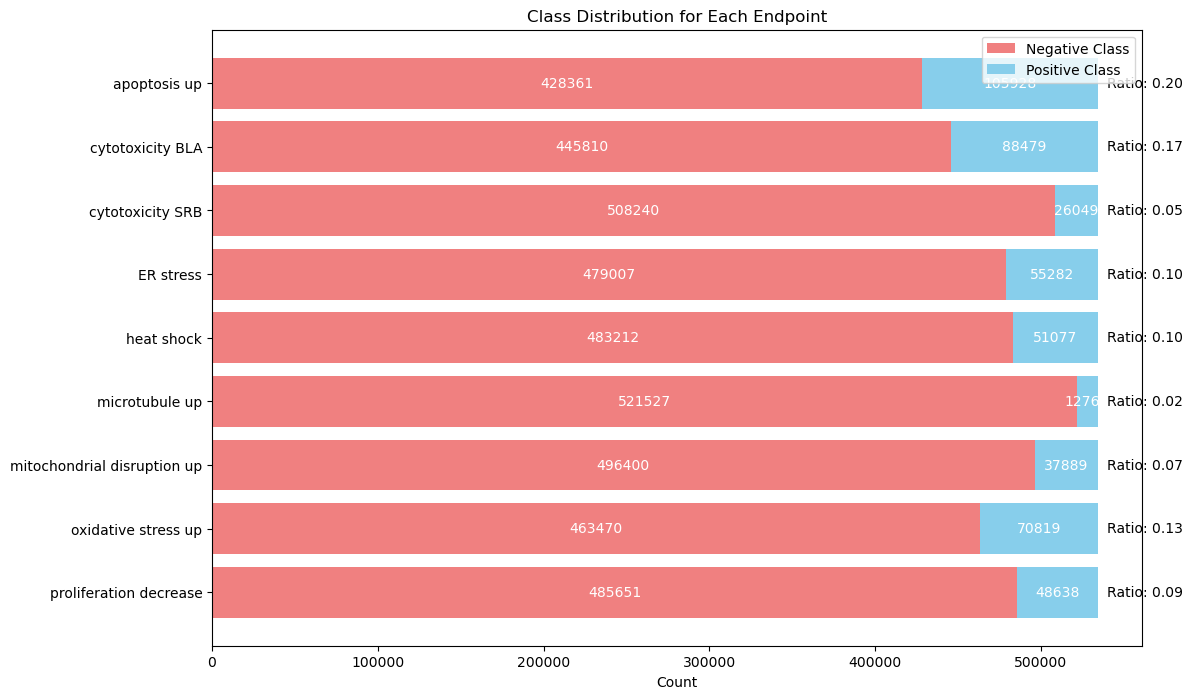

In [138]:
# get counts for positive and negative classes
positive_counts = endpoint_balance[1]
negative_counts = endpoint_balance[0]
endpoint_names = endpoint_balance.index

# plot the stacked horizontal bar chart
plt.figure(figsize=(12, 8))
plt.barh(endpoint_names, negative_counts, color='lightcoral', label='Negative Class')
plt.barh(endpoint_names, positive_counts, left=negative_counts, color='skyblue', label='Positive Class')

# labels and title
plt.xlabel('Count')
plt.title('Class Distribution for Each Endpoint')
plt.legend(loc='upper right')

# display values on bars
for index, (neg_count, pos_count) in enumerate(zip(negative_counts, positive_counts)):
    total_count = neg_count + pos_count
    plt.text(neg_count / 2, index, f"{neg_count}", va='center', ha='center', color='white')  # Negative class count
    plt.text(neg_count + pos_count / 2, index, f"{pos_count}", va='center', ha='center', color='white')  # Positive class count
    plt.text(total_count + 0.01 * total_count, index, f"Ratio: {(pos_count / total_count):.2f}", va='center', color='black')  # Ratio label

plt.gca().invert_yaxis()
plt.show()

- As it can be seen from the above endpoint label table, the true labels are ***heavily imbalanced***.

- Imbalanced classification tasks necessitates the use of ***F1-score***, which gives equal weight to ***precision*** (the proportion of correctly identified positives out of all predicted positives) and **recall** (the proportion of correctly identified positives out of actual positives).

- F1 is especially useful when ***positive cases are rare***, and you want to ***avoid*** false negatives (missing a positive case) while also limiting false positives (flagging negatives as positives). If you’re predicting cell behaviors or toxicities, a high F1 score indicates reliable detection of true positive cases (e.g., correctly identifying a toxicity effect).

- In biological settings, ***recall*** is often prioritized to avoid missing active endpoints, especially if detecting active cases is essential.

### Visualizing Folds

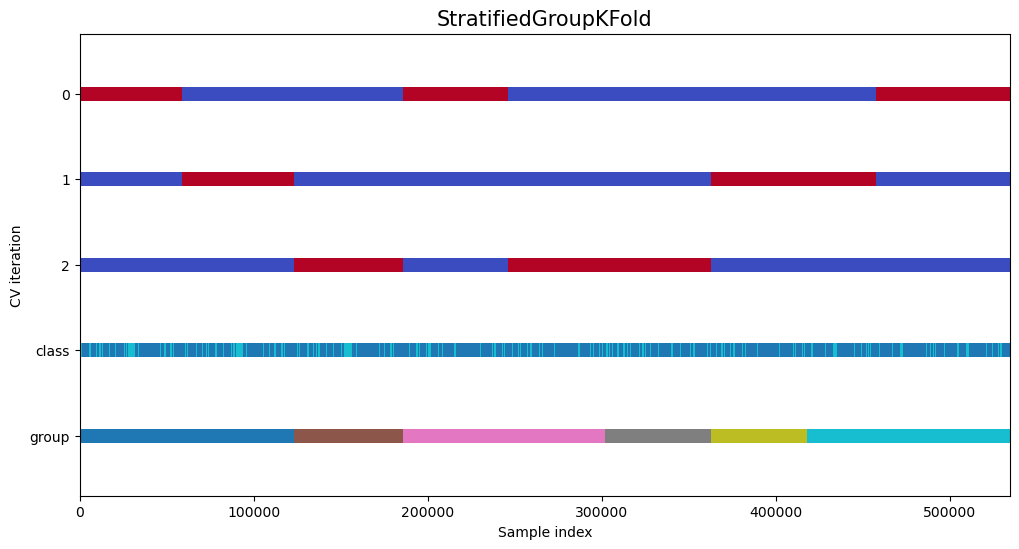

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold
import matplotlib  # Import matplotlib directly to access colormaps

# Define color maps with specified number of colors for groups and classes
n_groups = 10  # Number of distinct groups you have
cmap_data = matplotlib.colormaps["tab10"](np.linspace(0, 1, n_groups))  # "tab10" provides 10 distinct colors
cmap_cv = matplotlib.colormaps["coolwarm"]  # Color map for CV training/testing indices

def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    use_groups = "Group" in type(cv).__name__
    groups = group if use_groups else None
    
    # Generate the training/testing visualizations for each CV split
    for ii, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y, groups=groups)):
        # Fill in indices with the training/test groups
        indices = np.full(len(X), np.nan)  # Start with NaNs for empty spots
        indices[test_idx] = 1  # Mark test indices as 1
        indices[train_idx] = 0  # Mark train indices as 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=0, vmax=1,  # Specify limits for color mapping
        )

    # Plot the data classes at the end
    ax.scatter(
        range(len(X)), [n_splits + 0.5] * len(X), c=y, marker="_", lw=lw, cmap="tab10"
    )
    
    # Plot the groups at the end using a distinct color for each group
    ax.scatter(
        range(len(X)), [n_splits + 1.5] * len(X), c=group, marker="_", lw=lw, cmap="tab10"
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, len(X)]
    )
    ax.set_title(f"{type(cv).__name__}", fontsize=15)
    return ax

# Initialize data for plotting
fig, ax = plt.subplots(figsize=(12, 6))
n_splits = 3
cv = StratifiedGroupKFold(n_splits=n_splits)
y = biomorph_cell_stats['apoptosis up']
X = biomorph_cell_stats[predictors]
groups = biomorph_cell_stats['PlateID']

# Plot cross-validation indices
plot_cv_indices(cv, X, y, groups, ax, n_splits)
plt.show()

In [127]:
print(f'Unique GroupID: {len(biomorph_cell_stats['GroupID'].unique())}')
print(f'Unique WellID: {len(biomorph_cell_stats['WellID'].unique())}')
print(f'Unique CPD_NAME: {len(biomorph_cell_stats['CPD_NAME'].unique())}')
print(f'Unique PlateID: {len(biomorph_cell_stats['PlateID'].unique())}')

Unique GroupID: 850
Unique WellID: 230
Unique CPD_NAME: 334
Unique PlateID: 10


### Counting Groups' Positive Instances

In [ ]:
from collections import Counter
from sklearn.model_selection import StratifiedGroupKFold

# Example data (replace these with your actual data variables)
X = biomorph_cell_stats[predictor_columns[:1]]  # Predictor variables
y = biomorph_cell_stats['apoptosis up']  # Target variable
groups = biomorph_cell_stats['PlateID']  # Group identifiers (e.g., WellID + PlateID)

# Initialize StratifiedGroupKFold or your custom cross-validator
n_splits = 5
stratified_group_kfold = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=97)

# Iterate through each fold to inspect class distributions
for fold, (train_idx, test_idx) in enumerate(stratified_group_kfold.split(X, y, groups), 1):
    # Extract train and test sets
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    groups_train, groups_test = groups.iloc[train_idx], groups.iloc[test_idx]
    
    # Count class distribution in train and test sets
    train_class_dist = Counter(y_train)
    test_class_dist = Counter(y_test)
    
    # Count group class distribution in train and test sets
    train_group_dist = Counter((group, y_train[groups_train == group].values[0]) for group in set(groups_train))
    test_group_dist = Counter((group, y_test[groups_test == group].values[0]) for group in set(groups_test))
    
    # Print fold information
    print(f"\nFold {fold}:")
    print(f"  Train set - Overall class distribution: {train_class_dist}")
    print(f"  Train set - Grouped class distribution by Group and Class:")
    for (group, cls), count in train_group_dist.items():
        print(f"    Group {group} - Class {cls}: {count} samples")
    
    print(f"  Test set - Overall class distribution: {test_class_dist}")
    print(f"  Test set - Grouped class distribution by Group and Class:")
    for (group, cls), count in test_group_dist.items():
        print(f"    Group {group} - Class {cls}: {count} samples")


Fold 1:
  Train set - Overall class distribution: Counter({0: 350170, 1: 85400})
  Train set - Grouped class distribution by Group and Class:
    Group 24293 - Class 0: 1 samples
    Group 24294 - Class 0: 1 samples
    Group 24295 - Class 0: 1 samples
    Group 24296 - Class 0: 1 samples
    Group 24300 - Class 0: 1 samples
    Group 24301 - Class 0: 1 samples
    Group 24302 - Class 0: 1 samples
    Group 24280 - Class 0: 1 samples
  Test set - Overall class distribution: Counter({0: 78201, 1: 20538})
  Test set - Grouped class distribution by Group and Class:
    Group 24303 - Class 0: 1 samples
    Group 24279 - Class 0: 1 samples

Fold 2:
  Train set - Overall class distribution: Counter({0: 349051, 1: 90573})
  Train set - Grouped class distribution by Group and Class:
    Group 24293 - Class 0: 1 samples
    Group 24294 - Class 0: 1 samples
    Group 24295 - Class 0: 1 samples
    Group 24296 - Class 0: 1 samples
    Group 24302 - Class 0: 1 samples
    Group 24303 - Class 0: 1

# 3. Classifier Modeling

- Since each endpoint represents a separate type of activity, building ***separate classifiers*** for each endpoint (like apoptosis up) is a reasonable approach. This way, each classifier can be optimized for the characteristics of its specific endpoint. However, if these endpoints are often activated together, a multi-label classification model could be beneficial, as it learns patterns across the endpoints simultaneously. **Next: The potential for multi-label will be investigated.**

- Including ***compound names*** could be useful since certain compounds are known to induce specific responses, but encoding must be done carefully. **Next: Categorical data encoding will be investigated.**
- Scaling using ***StandardScaler*** is done to mitigate potential sensitivity problems that might occur in feature-scale-sensitive model types. Random forest is not one of them, but still it is good practice.
- Since each WellID has multiple FieldIDs, treating them as groups using ***StratifiedGroupKFold*** ensures that fields from the same well don’t appear in both training and test sets, preventing data leakage and preserving the independence of samples.

## Baseline v1

- One target endpoint
- Two predictor features
- One model (random forest)
- Stratified Cross-Validation
- No Grouped-Folding
- No hyperparemeter tuning

The model is able to successfully run with `F1 = 0.15` performance.

In [80]:
# logging configuration
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.FileHandler("simplified_model.log"), logging.StreamHandler()])

# set up variables
random_state = 97
data = biomorph_cell_stats
predictors = areashape_features[:2]
targets = endpoint_columns[:1]
prediction_results = []

# initialize cross-validation with StratifiedKFold (no grouping)
n_splits = 5
strat_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# initialize a RandomForest pipeline with scaling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=random_state, class_weight='balanced', n_jobs=-1))
])

# train a separate model for each endpoint
for endpoint in tqdm(targets, desc="Processing Endpoints", unit="endpoint"):

    # set the variables
    y = biomorph_cell_stats[endpoint]
    X = biomorph_cell_stats[predictors]

    # initiate an error-handler and run cross-validation to train and test the model
    try:
        scoring_metrics = ['accuracy', 'roc_auc', 'f1', 'precision', 'recall']
        cv_results = cross_validate(
            pipeline,
            X,
            y,
            cv=strat_kfold,
            scoring=scoring_metrics,
            return_train_score=False,
            n_jobs=-1
        )

        # aggregate metrics using np.nanmean to handle potential NaNs
        mean_accuracy = np.nanmean(cv_results['test_accuracy'])
        mean_roc_auc = np.nanmean(cv_results['test_roc_auc']) if 'test_roc_auc' in cv_results else np.nan
        mean_f1 = np.nanmean(cv_results['test_f1'])
        mean_precision = np.nanmean(cv_results['test_precision'])
        mean_recall = np.nanmean(cv_results['test_recall'])

        # append the results
        prediction_results.append({
            'Endpoint': endpoint,
            'Mean_Accuracy': mean_accuracy,
            'Mean_ROC_AUC': mean_roc_auc,
            'Mean_F1_Score': mean_f1,
            'Mean_Precision': mean_precision,
            'Mean_Recall': mean_recall
        })

        logging.info(
            f"Endpoint '{endpoint}' - Accuracy: {mean_accuracy:.4f}, "
            f"ROC AUC: {mean_roc_auc:.4f}, F1: {mean_f1:.4f}, "
            f"Precision: {mean_precision:.4f}, Recall: {mean_recall:.4f}"
        )

    except Exception as e:
        logging.error(f"An error occurred during modeling for endpoint '{endpoint}': {e}")
        prediction_results.append({
            'Endpoint': endpoint,
            'Mean_Accuracy': np.nan,
            'Mean_ROC_AUC': np.nan,
            'Mean_F1_Score': np.nan,
            'Mean_Precision': np.nan,
            'Mean_Recall': np.nan
        })

prediction_results_df = pd.DataFrame(prediction_results)
prediction_results_df

Processing Endpoints: 100%|██████████| 1/1 [01:05<00:00, 65.49s/endpoint]


,Endpoint,Mean_Accuracy,Mean_ROC_AUC,Mean_F1_Score,Mean_Precision,Mean_Recall
0,apoptosis up,0.72661,0.501202,0.152564,0.197943,0.12412


In [85]:
# logging configuration
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.FileHandler("simplified_model.log"), logging.StreamHandler()])

# set up variables
random_state = 97
data = biomorph_cell_stats
predictors = areashape_features[:2]
targets = endpoint_columns
prediction_results = []

# initialize cross-validation with StratifiedKFold (no grouping)
n_splits = 5
strat_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# initialize a RandomForest pipeline with scaling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=random_state, class_weight='balanced', n_jobs=-1))
])

# train a separate model for each endpoint
for endpoint in tqdm(targets, desc="Processing Endpoints", unit="endpoint"):

    # set the variables
    y = biomorph_cell_stats[endpoint]
    X = biomorph_cell_stats[predictors]

    # initiate an error-handler and run cross-validation to train and test the model
    try:
        scoring_metrics = ['accuracy', 'roc_auc', 'f1', 'precision', 'recall']
        cv_results = cross_validate(
            pipeline,
            X,
            y,
            cv=strat_kfold,
            scoring=scoring_metrics,
            return_train_score=False,
            n_jobs=-1
        )

        # aggregate metrics using np.nanmean to handle potential NaNs
        mean_accuracy = np.nanmean(cv_results['test_accuracy'])
        mean_roc_auc = np.nanmean(cv_results['test_roc_auc']) if 'test_roc_auc' in cv_results else np.nan
        mean_f1 = np.nanmean(cv_results['test_f1'])
        mean_precision = np.nanmean(cv_results['test_precision'])
        mean_recall = np.nanmean(cv_results['test_recall'])

        # append the results
        prediction_results.append({
            'Endpoint': endpoint,
            'Mean_Accuracy': mean_accuracy.round(4),
            'Mean_ROC_AUC': mean_roc_auc.round(4),
            'Mean_F1_Score': mean_f1.round(4),
            'Mean_Precision': mean_precision.round(4),
            'Mean_Recall': mean_recall.round(4)
        })

        logging.info(
            f"Endpoint '{endpoint}' - Accuracy: {mean_accuracy:.4f}, "
            f"ROC AUC: {mean_roc_auc:.4f}, F1: {mean_f1:.4f}, "
            f"Precision: {mean_precision:.4f}, Recall: {mean_recall:.4f}"
        )

    except Exception as e:
        logging.error(f"An error occurred during modeling for endpoint '{endpoint}': {e}")
        prediction_results.append({
            'Endpoint': endpoint,
            'Mean_Accuracy': np.nan,
            'Mean_ROC_AUC': np.nan,
            'Mean_F1_Score': np.nan,
            'Mean_Precision': np.nan,
            'Mean_Recall': np.nan
        })

prediction_results_df = pd.DataFrame(prediction_results)
prediction_results_df

Processing Endpoints: 100%|██████████| 9/9 [08:41<00:00, 57.90s/endpoint]


,Endpoint,Mean_Accuracy,Mean_ROC_AUC,Mean_F1_Score,Mean_Precision,Mean_Recall
0,apoptosis up,0.726610,0.501202,0.152564,0.197943,0.124120
1,cytotoxicity BLA,0.770595,0.498475,0.119179,0.163652,0.093722
2,cytotoxicity SRB,0.936327,0.498899,0.022295,0.044362,0.014894
3,ER stress,0.861292,0.500602,0.060828,0.101606,0.043410
4,heat shock,0.864440,0.499110,0.065034,0.095488,0.049332
5,microtubule up,0.969901,0.502178,0.008383,0.019672,0.005328
6,mitochondrial disruption up,0.902689,0.500749,0.040830,0.067816,0.029215
7,oxidative stress up,0.816833,0.501061,0.091921,0.134042,0.069949
8,proliferation decrease,0.878490,0.497635,0.050730,0.087823,0.035670


## Baseline v2

- One target endpoint
- Two predictor features
- `Multiple models (Random forest, logistic regression, gradient boosting)`
- Stratified Cross-Validation
- No Grouped-Folding
- No hyperparemeter tuning

The best performing model is logistic regression with `F1 = 0.27` score.

In [52]:
# logging configuration
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.FileHandler("simplified_model.log"), logging.StreamHandler()])

# set up variables
random_state = 97
data = biomorph_cell_stats
predictors = areashape_features[:2]
targets = endpoint_columns[:1]
prediction_results = []

# initialize cross-validation with StratifiedKFold (no grouping)
n_splits = 5
strat_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# define the models
models = {
    'RandomForest': RandomForestClassifier(random_state=random_state, class_weight='balanced', n_jobs=-1),
    'LogisticRegression': LogisticRegression(random_state=random_state, class_weight='balanced', max_iter=1000),
    'GradientBoosting': GradientBoostingClassifier(random_state=random_state)
}

# parse through each endpoint
for endpoint in targets:

    # set the variables
    y = biomorph_cell_stats[endpoint]
    X = biomorph_cell_stats[predictors]

    # parse through each model object
    for model_name, model in tqdm(models.items(), desc="Testing Models", unit="model"):

        # initialize the pipeline with scaling and the next available model
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])

        # initiate an error-handler and run cross-validation to train and test the model
        try:
            scoring_metrics = ['accuracy', 'roc_auc', 'f1', 'precision', 'recall']
            cv_results = cross_validate(
                pipeline,
                X,
                y,
                cv=strat_kfold,
                scoring=scoring_metrics,
                return_train_score=False,
                n_jobs=-1
            )

            # aggregate metrics using np.nanmean to handle potential NaNs
            mean_accuracy = np.nanmean(cv_results['test_accuracy'])
            mean_roc_auc = np.nanmean(cv_results['test_roc_auc']) if 'test_roc_auc' in cv_results else np.nan
            mean_f1 = np.nanmean(cv_results['test_f1'])
            mean_precision = np.nanmean(cv_results['test_precision'])
            mean_recall = np.nanmean(cv_results['test_recall'])

            # append the results
            prediction_results.append({
                'Endpoint': endpoint,
                'Model': model_name,
                'Mean_Accuracy': mean_accuracy,
                'Mean_ROC_AUC': mean_roc_auc,
                'Mean_F1_Score': mean_f1,
                'Mean_Precision': mean_precision,
                'Mean_Recall': mean_recall
            })

            logging.info(
                f"Endpoint '{endpoint}', Model '{model_name}' - "
                f"Accuracy: {mean_accuracy:.4f}, ROC AUC: {mean_roc_auc:.4f}, "
                f"F1: {mean_f1:.4f}, Precision: {mean_precision:.4f}, Recall: {mean_recall:.4f}"
            )

        except Exception as e:
            logging.error(f"An error occurred during modeling for endpoint '{endpoint}', model '{model_name}': {e}")
            prediction_results.append({
                'Endpoint': endpoint,
                'Model': model_name,
                'Mean_Accuracy': np.nan,
                'Mean_ROC_AUC': np.nan,
                'Mean_F1_Score': np.nan,
                'Mean_Precision': np.nan,
                'Mean_Recall': np.nan
            })

prediction_results_df = pd.DataFrame(prediction_results)
prediction_results_df

Testing Models: 100%|██████████| 3/3 [01:31<00:00, 30.43s/model]


,Endpoint,Model,Mean_Accuracy,Mean_ROC_AUC,Mean_F1_Score,Mean_Precision,Mean_Recall
0,apoptosis up,RandomForest,0.726610,0.501202,0.152564,0.197943,0.124120
1,apoptosis up,LogisticRegression,0.570389,0.516127,0.275245,0.206795,0.411448
2,apoptosis up,GradientBoosting,0.801701,0.515337,0.000189,0.280000,0.000094


## Baseline v3

- `All nine target endpoints`
- Two predictor features
- Multiple models (Random forest, logistic regression, gradient boosting)
- Stratified Cross-Validation
- No Grouped-Folding
- No hyperparemeter tuning

In all of the endpoints the best performing model is **logistic regression**.

In [86]:
# logging configuration
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.FileHandler("simplified_model.log"), logging.StreamHandler()])

# set up variables
random_state = 97
data = biomorph_cell_stats
predictors = areashape_features[:2]
targets = endpoint_columns
prediction_results = []

# initialize cross-validation with StratifiedKFold (no grouping)
n_splits = 5
strat_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# define the models
models = {
    'RandomForest': RandomForestClassifier(random_state=random_state, 
                                           class_weight='balanced',
                                           n_jobs=-1),
    'LogisticRegression': LogisticRegression(random_state=random_state, 
                                             class_weight='balanced', 
                                             max_iter=1000),
    'GradientBoosting': GradientBoostingClassifier(random_state=random_state)
}

# parse through each endpoint
for endpoint in targets:

    # set the variables
    y = biomorph_cell_stats[endpoint]
    X = biomorph_cell_stats[predictors]

    # parse through each model object
    for model_name, model in tqdm(models.items(), desc="Testing Models", unit="model"):

        # initialize the pipeline with scaling and the next available model
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])

        # initiate an error-handler and run cross-validation to train and test the model
        try:
            scoring_metrics = ['accuracy', 'roc_auc', 'f1', 'precision', 'recall']
            cv_results = cross_validate(
                pipeline,
                X,
                y,
                cv=strat_kfold,
                scoring=scoring_metrics,
                return_train_score=False,
                n_jobs=-1
            )

            # aggregate metrics using np.nanmean to handle potential NaNs
            mean_accuracy = np.nanmean(cv_results['test_accuracy'])
            mean_roc_auc = np.nanmean(cv_results['test_roc_auc']) if 'test_roc_auc' in cv_results else np.nan
            mean_f1 = np.nanmean(cv_results['test_f1'])
            mean_precision = np.nanmean(cv_results['test_precision'])
            mean_recall = np.nanmean(cv_results['test_recall'])

            # append the results
            prediction_results.append({
                'Endpoint': endpoint,
                'Model': model_name,
                'Mean_Accuracy': mean_accuracy,
                'Mean_ROC_AUC': mean_roc_auc,
                'Mean_F1_Score': mean_f1,
                'Mean_Precision': mean_precision,
                'Mean_Recall': mean_recall
            })

            logging.info(
                f"Endpoint '{endpoint}', Model '{model_name}' - "
                f"Accuracy: {mean_accuracy:.4f}, ROC AUC: {mean_roc_auc:.4f}, "
                f"F1: {mean_f1:.4f}, Precision: {mean_precision:.4f}, Recall: {mean_recall:.4f}"
            )

        except Exception as e:
            logging.error(f"An error occurred during modeling for endpoint '{endpoint}', model '{model_name}': {e}")
            prediction_results.append({
                'Endpoint': endpoint,
                'Model': model_name,
                'Mean_Accuracy': np.nan,
                'Mean_ROC_AUC': np.nan,
                'Mean_F1_Score': np.nan,
                'Mean_Precision': np.nan,
                'Mean_Recall': np.nan
            })

prediction_results_df = pd.DataFrame(prediction_results)
prediction_results_df

Testing Models:  33%|███▎      | 1/3 [01:00<02:00, 60.48s/model]/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-11-12 16:17:53,729 - INFO - Endpoint 'cytotoxicity BLA', Model 'LogisticRegression' - Accuracy: 0.5754, ROC AUC: 0.5155, F1: 0.2429, Precision: 0.1724, Recall: 0.4114
Testing Models:  67%|██████▋   | 2/3 [00:52<00:21, 21.90s/model]/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/metrics/_class

,Endpoint,Model,Mean_Accuracy,Mean_ROC_AUC,Mean_F1_Score,Mean_Precision,Mean_Recall
0,apoptosis up,RandomForest,0.726610,0.501202,0.152564,0.197943,0.124120
1,apoptosis up,LogisticRegression,0.570389,0.516127,0.275245,0.206795,0.411448
2,apoptosis up,GradientBoosting,0.801701,0.515337,0.000189,0.280000,0.000094
3,cytotoxicity BLA,RandomForest,0.770595,0.498475,0.119179,0.163652,0.093722
4,cytotoxicity BLA,LogisticRegression,0.575379,0.515525,0.242943,0.172366,0.411414
5,cytotoxicity BLA,GradientBoosting,0.834395,0.514306,0.000158,0.450000,0.000079
6,cytotoxicity SRB,RandomForest,0.936327,0.498899,0.022295,0.044362,0.014894
7,cytotoxicity SRB,LogisticRegression,0.616857,0.531537,0.095883,0.054174,0.416683
8,cytotoxicity SRB,GradientBoosting,0.951234,0.527901,0.000000,0.000000,0.000000
9,ER stress,RandomForest,0.861292,0.500602,0.060828,0.101606,0.043410


## Baseline v4

- All nine target endpoints
- Two predictor features
- Multiple models (Random forest, logistic regression, gradient boosting)
- Stratified Cross-Validation
- `Grouped by PlateID (to prevent model bias)`
- No hyperparemeter tuning

Grouping by PlateID works, compared to grouping by GroupID or WellID which causes too many splits to lack positive class instances. ***By grouping by PlateID we get rid of the model bias (by keeping the same-annotated cells together) while losing F1-score by only a small margin.***

In [124]:
# logging configuration
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.FileHandler("simplified_model.log"), logging.StreamHandler()])

# set up variables
random_state = 97
data = biomorph_cell_stats
predictors = areashape_features[:2]
targets = endpoint_columns
prediction_results = []

# initialize cross-validation with StratifiedGroupKFold (plateID as the grouping factor)
groups = data['PlateID']
n_splits = 3
strat_group_kfold = StratifiedGroupKFold(n_splits=n_splits,
                                         shuffle=True,
                                         random_state=random_state)

# define the models
models = {
    'RandomForest': RandomForestClassifier(random_state=random_state, 
                                           class_weight='balanced',
                                           n_jobs=-1),
    'LogisticRegression': LogisticRegression(random_state=random_state, 
                                             class_weight='balanced', 
                                             max_iter=1000),
    'GradientBoosting': GradientBoostingClassifier(random_state=random_state)
}

# parse through each endpoint
for endpoint in targets:

    # set the variables
    y = data[endpoint]
    X = data[predictors]

    # parse through each model object
    for model_name, model in tqdm(models.items(), desc="Testing Models", unit="model"):

        # initialize the pipeline with scaling and the next available model
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])

        # initiate an error-handler and run cross-validation to train and test the model
        try:
            scoring_metrics = ['accuracy', 'roc_auc', 'f1', 'precision', 'recall']
            cv_results = cross_validate(
                pipeline,
                X,
                y,
                cv=strat_group_kfold.split(X, y, groups=groups), # use PlateID as grouping variable
                scoring=scoring_metrics,
                return_train_score=False,
                n_jobs=-1
            )

            # aggregate metrics using np.nanmean to handle potential NaNs
            mean_accuracy = np.nanmean(cv_results['test_accuracy'])
            mean_roc_auc = np.nanmean(cv_results['test_roc_auc']) if 'test_roc_auc' in cv_results else np.nan
            mean_f1 = np.nanmean(cv_results['test_f1'])
            mean_precision = np.nanmean(cv_results['test_precision'])
            mean_recall = np.nanmean(cv_results['test_recall'])

            # append the results
            prediction_results.append({
                'Endpoint': endpoint,
                'Model': model_name,
                'Mean_Accuracy': mean_accuracy,
                'Mean_ROC_AUC': mean_roc_auc,
                'Mean_F1_Score': mean_f1,
                'Mean_Precision': mean_precision,
                'Mean_Recall': mean_recall
            })

            logging.info(
                f"Endpoint '{endpoint}', Model '{model_name}' - "
                f"Accuracy: {mean_accuracy:.4f}, ROC AUC: {mean_roc_auc:.4f}, "
                f"F1: {mean_f1:.4f}, Precision: {mean_precision:.4f}, Recall: {mean_recall:.4f}"
            )

        except Exception as e:
            logging.error(f"An error occurred during modeling for endpoint '{endpoint}', model '{model_name}': {e}")
            prediction_results.append({
                'Endpoint': endpoint,
                'Model': model_name,
                'Mean_Accuracy': np.nan,
                'Mean_ROC_AUC': np.nan,
                'Mean_F1_Score': np.nan,
                'Mean_Precision': np.nan,
                'Mean_Recall': np.nan
            })

prediction_results_df = pd.DataFrame(prediction_results)
prediction_results_df

Testing Models:  67%|██████▋   | 2/3 [00:28<00:11, 11.88s/model]/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2024-11-13 16:50:14,144 - INFO - Endpoint 'cytotoxicity SRB', Model 'GradientBoosting' - Accuracy: 0.9517, ROC AUC: 0.5293, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Testing Models:  67%|██████▋   | 2/3 [00:33<00:13, 13.88s/model]/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2024-11-13 16:51:57,201 - INFO

,Endpoint,Model,Mean_Accuracy,Mean_ROC_AUC,Mean_F1_Score,Mean_Precision,Mean_Recall
0,apoptosis up,RandomForest,0.729428,0.500334,0.149665,0.198770,0.120297
1,apoptosis up,LogisticRegression,0.570353,0.515776,0.274584,0.206408,0.410541
2,apoptosis up,GradientBoosting,0.801753,0.513702,0.000287,0.395623,0.000143
3,cytotoxicity BLA,RandomForest,0.773655,0.499794,0.117236,0.165558,0.092066
4,cytotoxicity BLA,LogisticRegression,0.574317,0.514971,0.241758,0.171472,0.412654
5,cytotoxicity BLA,GradientBoosting,0.835060,0.514449,0.000101,0.177778,0.000051
6,cytotoxicity SRB,RandomForest,0.938465,0.499562,0.021737,0.047100,0.014273
7,cytotoxicity SRB,LogisticRegression,0.616869,0.532652,0.094800,0.053560,0.417286
8,cytotoxicity SRB,GradientBoosting,0.951681,0.529259,0.000000,0.000000,0.000000
9,ER stress,RandomForest,0.864955,0.499538,0.057355,0.100930,0.040552


## Baseline v5

- All nine target endpoints
- `Ten predictor features`
- `Single model (logistic regression)`
- Stratified Cross-Validation
- Grouped by PlateID (to prevent model bias)
- No hyperparemeter tuning

Introducing more features into logistic regression increased its F1-score by keeping the precision at the same level and increasing its recall performance by .07-.09 points.

In [126]:
# logging configuration
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.FileHandler("simplified_model.log"), logging.StreamHandler()])

# set up variables
random_state = 97
data = biomorph_cell_stats
predictors = areashape_features[:11]
targets = endpoint_columns
prediction_results = []

# initialize cross-validation with StratifiedGroupKFold (plateID as the grouping factor)
groups = data['PlateID']
n_splits = 3
strat_group_kfold = StratifiedGroupKFold(n_splits=n_splits,
                                         shuffle=True,
                                         random_state=random_state)

# define the models
models = {
    # 'RandomForest': RandomForestClassifier(random_state=random_state, 
    #                                        class_weight='balanced',
    #                                        n_jobs=-1),
    'LogisticRegression': LogisticRegression(random_state=random_state, 
                                             class_weight='balanced', 
                                             max_iter=1000),
    # 'GradientBoosting': GradientBoostingClassifier(random_state=random_state)
}

# parse through each endpoint
for endpoint in targets:

    # set the variables
    y = data[endpoint]
    X = data[predictors]

    # parse through each model object
    for model_name, model in tqdm(models.items(), desc="Testing Models", unit="model"):

        # initialize the pipeline with scaling and the next available model
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])

        # initiate an error-handler and run cross-validation to train and test the model
        try:
            scoring_metrics = ['accuracy', 'roc_auc', 'f1', 'precision', 'recall']
            cv_results = cross_validate(
                pipeline,
                X,
                y,
                cv=strat_group_kfold.split(X, y, groups=groups), # use PlateID as grouping variable
                scoring=scoring_metrics,
                return_train_score=False,
                n_jobs=-1
            )

            # aggregate metrics using np.nanmean to handle potential NaNs
            mean_accuracy = np.nanmean(cv_results['test_accuracy'])
            mean_roc_auc = np.nanmean(cv_results['test_roc_auc']) if 'test_roc_auc' in cv_results else np.nan
            mean_f1 = np.nanmean(cv_results['test_f1'])
            mean_precision = np.nanmean(cv_results['test_precision'])
            mean_recall = np.nanmean(cv_results['test_recall'])

            # append the results
            prediction_results.append({
                'Endpoint': endpoint,
                'Model': model_name,
                'Mean_Accuracy': mean_accuracy,
                'Mean_ROC_AUC': mean_roc_auc,
                'Mean_F1_Score': mean_f1,
                'Mean_Precision': mean_precision,
                'Mean_Recall': mean_recall
            })

            logging.info(
                f"Endpoint '{endpoint}', Model '{model_name}' - "
                f"Accuracy: {mean_accuracy:.4f}, ROC AUC: {mean_roc_auc:.4f}, "
                f"F1: {mean_f1:.4f}, Precision: {mean_precision:.4f}, Recall: {mean_recall:.4f}"
            )

        except Exception as e:
            logging.error(f"An error occurred during modeling for endpoint '{endpoint}', model '{model_name}': {e}")
            prediction_results.append({
                'Endpoint': endpoint,
                'Model': model_name,
                'Mean_Accuracy': np.nan,
                'Mean_ROC_AUC': np.nan,
                'Mean_F1_Score': np.nan,
                'Mean_Precision': np.nan,
                'Mean_Recall': np.nan
            })

prediction_results_df = pd.DataFrame(prediction_results)
prediction_results_df

Testing Models: 100%|██████████| 1/1 [00:00<00:00,  1.05model/s]


,Endpoint,Model,Mean_Accuracy,Mean_ROC_AUC,Mean_F1_Score,Mean_Precision,Mean_Recall
0,apoptosis up,LogisticRegression,0.528742,0.524776,0.295917,0.210133,0.500327
1,cytotoxicity BLA,LogisticRegression,0.537016,0.521506,0.256424,0.174592,0.485225
2,cytotoxicity SRB,LogisticRegression,0.559623,0.549082,0.100227,0.055657,0.510951
3,ER stress,LogisticRegression,0.548967,0.531192,0.181800,0.111611,0.490976
4,heat shock,LogisticRegression,0.526229,0.508856,0.168851,0.102735,0.484766
5,microtubule up,LogisticRegression,0.569925,0.546516,0.052029,0.027481,0.492716
6,mitochondrial disruption up,LogisticRegression,0.520057,0.517009,0.121534,0.069534,0.503706
7,oxidative stress up,LogisticRegression,0.538725,0.518237,0.214896,0.138697,0.478100
8,proliferation decrease,LogisticRegression,0.538079,0.536673,0.167153,0.100002,0.510649


## Baseline v6

- All nine target endpoints
- Ten predictor features
- `Multiple models (Random forest, logistic regression, gradient boosting)`
- Stratified Cross-Validation
- Grouped by PlateID (to prevent model bias)
- No hyperparemeter tuning

When more features are also introduced to random forest and gradient boosting, they had better precision but severely worse recall performance due to:
- Their complex tree-based nature overfitting the models
- Lack of feature importance algorithm
- Class imbalance causing prioritization in the (negative) majority class

In [128]:
# logging configuration
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.FileHandler("simplified_model.log"), logging.StreamHandler()])

# set up variables
random_state = 97
data = biomorph_cell_stats
predictors = areashape_features[:11]
targets = endpoint_columns
prediction_results = []

# initialize cross-validation with StratifiedGroupKFold (plateID as the grouping factor)
groups = data['PlateID']
n_splits = 3
strat_group_kfold = StratifiedGroupKFold(n_splits=n_splits,
                                         shuffle=True,
                                         random_state=random_state)

# define the models
models = {
    'RandomForest': RandomForestClassifier(random_state=random_state, 
                                           class_weight='balanced',
                                           n_jobs=-1),
    'LogisticRegression': LogisticRegression(random_state=random_state, 
                                             class_weight='balanced', 
                                             max_iter=1000),
    'GradientBoosting': GradientBoostingClassifier(random_state=random_state)
}

# parse through each endpoint
for endpoint in targets:

    # set the variables
    y = data[endpoint]
    X = data[predictors]

    # parse through each model object
    for model_name, model in tqdm(models.items(), desc="Testing Models", unit="model"):

        # initialize the pipeline with scaling and the next available model
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])

        # initiate an error-handler and run cross-validation to train and test the model
        try:
            scoring_metrics = ['accuracy', 'roc_auc', 'f1', 'precision', 'recall']
            cv_results = cross_validate(
                pipeline,
                X,
                y,
                cv=strat_group_kfold.split(X, y, groups=groups), # use PlateID as grouping variable
                scoring=scoring_metrics,
                return_train_score=False,
                n_jobs=-1
            )

            # aggregate metrics using np.nanmean to handle potential NaNs
            mean_accuracy = np.nanmean(cv_results['test_accuracy'])
            mean_roc_auc = np.nanmean(cv_results['test_roc_auc']) if 'test_roc_auc' in cv_results else np.nan
            mean_f1 = np.nanmean(cv_results['test_f1'])
            mean_precision = np.nanmean(cv_results['test_precision'])
            mean_recall = np.nanmean(cv_results['test_recall'])

            # append the results
            prediction_results.append({
                'Endpoint': endpoint,
                'Model': model_name,
                'Mean_Accuracy': mean_accuracy,
                'Mean_ROC_AUC': mean_roc_auc,
                'Mean_F1_Score': mean_f1,
                'Mean_Precision': mean_precision,
                'Mean_Recall': mean_recall
            })

            logging.info(
                f"Endpoint '{endpoint}', Model '{model_name}' - "
                f"Accuracy: {mean_accuracy:.4f}, ROC AUC: {mean_roc_auc:.4f}, "
                f"F1: {mean_f1:.4f}, Precision: {mean_precision:.4f}, Recall: {mean_recall:.4f}"
            )

        except Exception as e:
            logging.error(f"An error occurred during modeling for endpoint '{endpoint}', model '{model_name}': {e}")
            prediction_results.append({
                'Endpoint': endpoint,
                'Model': model_name,
                'Mean_Accuracy': np.nan,
                'Mean_ROC_AUC': np.nan,
                'Mean_F1_Score': np.nan,
                'Mean_Precision': np.nan,
                'Mean_Recall': np.nan
            })

prediction_results_df = pd.DataFrame(prediction_results)
prediction_results_df

Testing Models:   0%|          | 0/3 [00:00<?, ?model/s]/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2024-11-13 17:45:57,664 - INFO - Endpoint 'heat shock', Model 'RandomForest' - Accuracy: 0.9004, ROC AUC: 0.5020, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
Testing Models:   0%|          | 0/3 [00:00<?, ?model/s]/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/sit

,Endpoint,Model,Mean_Accuracy,Mean_ROC_AUC,Mean_F1_Score,Mean_Precision,Mean_Recall
0,apoptosis up,RandomForest,0.801722,0.506489,0.001448,0.429262,0.000725
1,apoptosis up,LogisticRegression,0.528742,0.524776,0.295917,0.210133,0.500327
2,apoptosis up,GradientBoosting,0.801781,0.524867,0.001269,0.520899,0.000636
3,cytotoxicity BLA,RandomForest,0.835050,0.506139,0.000090,0.185185,0.000045
4,cytotoxicity BLA,LogisticRegression,0.537016,0.521506,0.256424,0.174592,0.485225
5,cytotoxicity BLA,GradientBoosting,0.835076,0.521314,0.000351,0.577778,0.000176
6,cytotoxicity SRB,RandomForest,0.951677,0.512413,0.000000,0.000000,0.000000
7,cytotoxicity SRB,LogisticRegression,0.559623,0.549082,0.100227,0.055657,0.510951
8,cytotoxicity SRB,GradientBoosting,0.951641,0.546574,0.000135,0.073260,0.000068
9,ER stress,RandomForest,0.897729,0.507596,0.000212,0.466667,0.000106


## Baseline v7

- All nine target endpoints
- `All 54 area_shape features`
- `Multiple models (Random forest, logistic regression, gradient boosting)`
- Stratified Cross-Validation
- Grouped by PlateID (to prevent model bias)
- No hyperparemeter tuning
- `Feature selection: Multiple algorithms (VarianceThreshold, SelectKBest, SelectFromModel_RF, RFE_DecisionTree)`

In [135]:
# logging configuration
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.FileHandler("simplified_model.log"), logging.StreamHandler()])

# set up variables
random_state = 97
data = biomorph_cell_stats
predictors = areashape_features[:]
targets = endpoint_columns
prediction_results = []

# initialize cross-validation with StratifiedGroupKFold (plateID as the grouping factor)
groups = data['PlateID']
n_splits = 3
strat_group_kfold = StratifiedGroupKFold(n_splits=n_splits,
                                         shuffle=True,
                                         random_state=random_state)

# define the models and feature selectors
models = {
    'RandomForest': RandomForestClassifier(random_state=random_state, 
                                           class_weight='balanced',
                                           n_jobs=-1),
    'LogisticRegression': LogisticRegression(random_state=random_state, 
                                             class_weight='balanced', 
                                             max_iter=1000),
    'GradientBoosting': GradientBoostingClassifier(random_state=random_state)
}

feature_selectors = {
    'VarianceThreshold': VarianceThreshold(threshold=0.1),
    'SelectKBest': SelectKBest(k=5),  # Adjust 'k' as needed
    'SelectFromModel_RF': SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=random_state, n_jobs=-1)),
    'RFE_DecisionTree': RFE(estimator=DecisionTreeClassifier(random_state=random_state), n_features_to_select=5)  # Adjust 'n_features_to_select' as needed
}

# parse through each endpoint
for endpoint in targets:

    # set the variables
    y = data[endpoint]
    X = data[predictors]

    # parse through each model object
    for model_name, model in tqdm(models.items(), desc="Testing Models", unit="model"):
        for selector_name, selector in feature_selectors.items():

            # start timer
            t1 = time.time()

            # initialize the pipeline
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('feature_selection', selector), # add feature selector into the pipeline
                ('classifier', model)
            ])

            # initiate an error-handler and run cross-validation to train and test the model
            try:
                scoring_metrics = ['accuracy', 'roc_auc', 'f1', 'precision', 'recall']
                cv_results = cross_validate(
                    pipeline,
                    X,
                    y,
                    cv=strat_group_kfold.split(X, y, groups=groups), # use PlateID as grouping variable
                    scoring=scoring_metrics,
                    return_train_score=False,
                    n_jobs=-1
                )

                # calculate elapsed time
                t2 = time.time() - t1

                # aggregate metrics using np.nanmean to handle potential NaNs
                mean_accuracy = np.nanmean(cv_results['test_accuracy'])
                mean_roc_auc = np.nanmean(cv_results['test_roc_auc']) if 'test_roc_auc' in cv_results else np.nan
                mean_f1 = np.nanmean(cv_results['test_f1'])
                mean_precision = np.nanmean(cv_results['test_precision'])
                mean_recall = np.nanmean(cv_results['test_recall'])

                # append the results
                prediction_results.append({
                    'Endpoint': endpoint,
                    'Model': model_name,
                    'Feature_Selector': selector_name,
                    'Mean_Accuracy': mean_accuracy,
                    'Mean_ROC_AUC': mean_roc_auc,
                    'Mean_F1_Score': mean_f1,
                    'Mean_Precision': mean_precision,
                    'Mean_Recall': mean_recall,
                    'Time': t2  # Record the elapsed time
                })

                logging.info(
                    f"Endpoint '{endpoint}', Model '{model_name}', Feature Selector '{selector_name}' - "
                    f"Accuracy: {mean_accuracy:.4f}, ROC AUC: {mean_roc_auc:.4f}, "
                    f"F1: {mean_f1:.4f}, Precision: {mean_precision:.4f}, Recall: {mean_recall:.4f}, "
                    f"Time: {t2:.2f}s"
                )

            except Exception as e:
                logging.error(f"An error occurred during modeling for endpoint '{endpoint}', model '{model_name}', feature selector '{selector_name}': {e}")
                prediction_results.append({
                    'Endpoint': endpoint,
                    'Model': model_name,
                    'Feature_Selector': selector_name,
                    'Mean_Accuracy': np.nan,
                    'Mean_ROC_AUC': np.nan,
                    'Mean_F1_Score': np.nan,
                    'Mean_Precision': np.nan,
                    'Mean_Recall': np.nan,
                    'Time': np.nan  # Record NaN if an error occurred
                })

prediction_results_df = pd.DataFrame(prediction_results)
prediction_results_df

Testing Models:   0%|          | 0/3 [00:00<?, ?model/s]2024-11-14 00:03:29,917 - INFO - Endpoint 'apoptosis up', Model 'RandomForest', Feature Selector 'VarianceThreshold' - Accuracy: 0.8017, ROC AUC: 0.5113, F1: 0.0010, Precision: 0.4459, Recall: 0.0005, Time: 190.27s
2024-11-14 00:04:40,703 - INFO - Endpoint 'apoptosis up', Model 'RandomForest', Feature Selector 'SelectKBest' - Accuracy: 0.7983, ROC AUC: 0.5065, F1: 0.0124, Precision: 0.2145, Recall: 0.0064, Time: 70.78s
2024-11-14 00:11:26,252 - INFO - Endpoint 'apoptosis up', Model 'RandomForest', Feature Selector 'SelectFromModel_RF' - Accuracy: 0.8017, ROC AUC: 0.5110, F1: 0.0012, Precision: 0.5349, Recall: 0.0006, Time: 405.55s
2024-11-14 00:47:05,812 - INFO - Endpoint 'apoptosis up', Model 'RandomForest', Feature Selector 'RFE_DecisionTree' - Accuracy: 0.8014, ROC AUC: 0.5067, F1: 0.0039, Precision: 0.3491, Recall: 0.0020, Time: 2139.56s
Testing Models:  33%|███▎      | 1/3 [46:46<1:33:32, 2806.16s/model]2024-11-14 00:47:10,28

KeyboardInterrupt: 